# Information Retrieval System using BERT-Networks

The goal of this notebook is to develop a document retrieval system, in order to return titles of scientific papers containing the answer to a given user question. 

We are going to use the _COVID-19 Open Research Dataset_, and answer questions regarding COVID-19. 

## Import Libraries

In [1]:
# Pre-trained models from SBERT
!pip install -U sentence-transformers
from sentence_transformers import SentenceTransformer, util
# For data vizualization 
import matplotlib as mpl
import matplotlib.pyplot as plt
# For large and multi-dimensional arrays
import numpy as np
# For basic cleaning and data preprocessing 
import re
# For data manipulation and analysis
import pandas as pd
import nltk
nltk.download('punkt')
# fancy progress bar
from tqdm import tqdm 
# time measurements
import time
# some math
import math
import copy
# metrics
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

Requirement already up-to-date: sentence-transformers in /usr/local/lib/python3.6/dist-packages (0.4.1.2)
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## CORD-19 Dataset

The dataset is given to us as many different `JSON` files, each one containing one unique paper. In order to get the information and the text of each paper, we must parse akk the files. 

### Parsing the Dataset

First up, we are going to gather the details of each paper from the json files. This code will be executed only once, and then the data will be saved to a csv file, because the parsing of all the papers takes extreme amount of time. The fields of the dataframe that we are going to generate are:
 - __ID__: ID of the paper, given in hex
 - __Title__: The title of the paper, if available
 - __Abstract__: The abstract of the paper, if available
 - __Sections__: The different sections of the paper
 - __Text__:The full text of the paper.

Initially, we are going to keep all this info, as it will be usefull in the creation of the embeddings. We will later narrow down the creation of embeddings, as it takes hours to build them for the full info of each paper.

When it comes down to different containings of the papers (references, authors, schemas), we will completely ignore them, as the are highly unlikely to answer to any question at all.

In [ ]:
import os
import json
import pandas as pd 

# keep only the unique elements of a list
def unique_list(l):
    ulist = []
    [ulist.append(x) for x in l if x not in ulist]
    return ulist

# the files are stored here
dir_name = "/content/drive/MyDrive/tn2/comm_use_subset"

# lists to hold each paper's info
ids = []
titles = []
abstracts = []
texts = []
sections = []

# parse each file in the directory
for i,filename in enumerate(os.listdir(dir_name)):
    if i % 100 == 0:
        print(i, "/", 9000)
    # open the file
    with open(os.path.join(dir_name, filename), 'r') as f:
        # load the json values
        values = json.load(f)
        # id of the paper
        ids.append(values['paper_id'])
        # title of the paper
        titles.append(values['metadata']['title'])
        # there might, and might not be an abstract
        if (values['abstract']):
            abstracts.append(values['abstract'][0]['text'])
        else:
            abstracts.append("")
        # a string that will store each text field of the body_text
        text = ""
        section = ""
        # parse the first body_Text values, and append to the original string
        for i, l in enumerate(values['body_text']):
            text = text + l['text']
            section = section + l['section'] + '. '
        # simple form of preprocessing: I noticed that many papers have this string in their text, thus we remove it
        text = text.replace("a1111111111", "")
        texts.append(text)
        
        section = ' '.join(unique_list(section.split()))
        sections.append(section)


# create a dict of the info that we gathered
data = {'id':ids, 'title':titles, 'abstract':abstracts, 'text':texts, 'sections':sections}
# create a dataframe from it
df = pd.DataFrame(data)
# and save it to a csv form for later use
df.to_csv("/content/drive/MyDrive/tn2/new_dataset.csv")
# print the head to check (althoufh google has an awful way of printing dfs)
# df.head

Each time, this cell will be executed in order to load the dataset from the csv file that we saved it to using the above function.

In [2]:
import pandas as pd 

df = pd.read_csv('/content/drive/MyDrive/tn2/new_dataset.csv')
df.info

<bound method DataFrame.info of       Unnamed: 0  ...                                           sections
0              0  ...  . Appendix Supplementary Methods. Human primer...
1              1  ...  Introduction. Approximate Bayesian Computation...
2              2  ...  INTRODUCTION. THE MAIN METHODS USED TO PRODUCE...
3              3  ...  Introduction. Methods. Amino acid composition ...
4              4  ...  . RESULTS. DISCUSSION. Role of Unfolded-Protei...
...          ...  ...                                                ...
8995        8995  ...  Introduction. Epidemiological Data. Statistica...
8996        8996  ...  Introduction. Population health. Globalisation...
8997        8997  ...  Background. Cohort study population and enroll...
8998        8998  ...  Background. General expression levels of candi...
8999        8999  ...  Background. (Non-) synonymous substitutions in...

[9000 rows x 6 columns]>

Let's take a look at some elements of the dataset.

In [3]:
df.head()

,Unnamed: 0,id,title,abstract,text,sections
0,0,2ec6a171036b53b0c21a39abdfd12756fd02ace6,NaN,NaN,.Appendix Table S1 . Primer sequences for dete...,. Appendix Supplementary Methods. Human primer...
1,1,69ef51ebe3e2ce0b8d6fc292b06b293ba2942bd7,Phylodynamic Inference and Model Assessment wi...,A key priority in infectious disease research ...,"Many infectious pathogens, most notably RNA vi...",Introduction. Approximate Bayesian Computation...
2,2,7722e2866e2b7849cc2f3175430a1048d97b71d9,Use of Transgenic Animals in Biotechnology: Pr...,"During the past two decades, there have been n...",After the successful expression of the first r...,INTRODUCTION. THE MAIN METHODS USED TO PRODUCE...
3,3,31b6292728805572de28133c6eb02ed1d44ef211,Bioinformatics and Biology Insights o r I g I ...,Background: Precise determination of conformat...,The identification of conformational epitopes ...,Introduction. Methods. Amino acid composition ...
4,4,8812b0579ea75d59a8dca6407431a3f716728556,Quantitative Proteomic Analysis Reveals Unfold...,Severe fever with thrombocytopenia syndrome (S...,S evere fever with thrombocytopenia syndrome v...,. RESULTS. DISCUSSION. Role of Unfolded-Protei...


### Preprocessing

Given the nature of this task, we are not going to apply the amount of preprocessing that we did in the previous assingments. 

If we attempt to lemmatize the sentences, it will be a complete disaster, as the user wants answers to questions, thus the strings return would not be readable.

The only preprocessing methods that are applicable in this purpose, is eliminating capital letters, and removing web links from the text.

In [4]:
def text_normalization(x):
    # convert to lowercase
    x = x.lower()
    # remove links
    x = re.sub(r'^www?.*[\r\n]*.com', '', x)

    return x

In [5]:
def preprocess(input_df):
     # Remove rows with missing values in column col
    input_df.dropna(inplace=True)

    # apply the normalization techniques
    input_df.abstract = df.abstract.apply(lambda x: text_normalization(x))
    input_df.text = df.text.apply(lambda x: text_normalization(x))
    input_df.sections = df.sections.apply(lambda x: text_normalization(x))
    
    # return processed input_df
    return input_df   

Let's now apply those techniques in our dataset.


In [6]:
df = preprocess(df)
df.head()

,Unnamed: 0,id,title,abstract,text,sections
1,1,69ef51ebe3e2ce0b8d6fc292b06b293ba2942bd7,Phylodynamic Inference and Model Assessment wi...,a key priority in infectious disease research ...,"many infectious pathogens, most notably rna vi...",introduction. approximate bayesian computation...
2,2,7722e2866e2b7849cc2f3175430a1048d97b71d9,Use of Transgenic Animals in Biotechnology: Pr...,"during the past two decades, there have been n...",after the successful expression of the first r...,introduction. the main methods used to produce...
3,3,31b6292728805572de28133c6eb02ed1d44ef211,Bioinformatics and Biology Insights o r I g I ...,background: precise determination of conformat...,the identification of conformational epitopes ...,introduction. methods. amino acid composition ...
4,4,8812b0579ea75d59a8dca6407431a3f716728556,Quantitative Proteomic Analysis Reveals Unfold...,severe fever with thrombocytopenia syndrome (s...,s evere fever with thrombocytopenia syndrome v...,. results. discussion. role of unfolded-protei...
5,5,1c7d1097a0fc23516fc084e127333ec4bbf9ca94,viruses Ebola Virus Entry: From Molecular Char...,ebola virus disease (evd) is one of the most l...,the genus ebolavirus of the filoviridae family...,introduction. viral models for drug discovery ...


## Question Answering Mechanism

In order to answer the questions, the general idea is to create embeddings for each sentence of each paper, and then return the most similar to the query asked, as well as the paper that contains it. 

However, it is rather slow to create embeddings for the full text of each paper, thus I came down to an idea in order to narrow-down the search for a paper containing an appropriate answer.

Initially, embeddings are created only for the __abstract__ and the __sections__ of each paper. We then keep the __k most similar__ regarding this info, and we fully expand the embeddings only for those k. 

This will reduce the runtime by a lot: the calculation of the embeddings for the top k papers (usually with k = 100), takes about 10 mins, as well as the creation of the embeddings of the abstract for all the papers.

It is quite clear that the embeddings of the abstract need to be created only one time, and thus I created a class, who's constructor is creating those embeddings, and then for each questions computes the embeddings of the full text of the initially most similar papers, given of course the model that the user wants to use

#### Class for Information Retrieval

In [7]:
class Query_Answering():
    # init function of the class: create the general embeddings, same for every question
    def __init__(self, model, df, narrowed):
        # start counting the time
        start_time = time.time()

        # keep usefull info
        self.model = model
        self.narrowed = narrowed
        self.df = df
        # keep track of the metrics
        self.time_elapsed = 0
        self.title_accuracy = 0
        self.passage_accuracy = 0
        self.questions_asked = 0

        papers_tokenized = []
        # parse the df to tokenize each sentence
        for i in range(len(self.df)):
            # ge the abstract
            abstract = nltk.tokenize.sent_tokenize(self.df.iloc[i].abstract)
            # and the sections of the paper
            sections =  nltk.tokenize.sent_tokenize(self.df.iloc[i].sections)
            # concat to retrieve all the sentences
            sentences = abstract + sections
            # append to the papers list
            papers_tokenized.append(sentences)

        # list to store all the general embeddings
        self.general_embeddings = []
        # create embeddings for each sentence that we tokenized
  
        for i in tqdm(range(len(papers_tokenized)), desc="Creating the embeddings...", position=0, leave=True): 
            self.general_embeddings.append(model.encode(papers_tokenized[i], convert_to_tensor=True))

        self.time_elapsed = time.time() - start_time


    def initially_most_similar(self, question_emb):

        # a numpy array to store the similarities of the sentence with each paper, while considering only the abstract and the sections
        general_similarities = []
        # itterate through all the embeddings
        for i, x in enumerate(self.general_embeddings):
            # create a list with the cosine similarities of each sentence of the paper with the question
            cosines = util.pytorch_cos_sim(question_emb, x).max()
            # and store the max of them
            general_similarities.append((i, cosines))

        # the most similar papers are those with the grater similarities among all in the df
        most_similar = [element[0] for element in sorted(general_similarities, key=lambda x: x[1], reverse=True)[:self.narrowed]]
        # for those papers, tokenize them again, but this time, add their body texts
        narrowed_tokenized = []

        for paper in most_similar:
            # include the abstract
            abstract = nltk.tokenize.sent_tokenize(self.df.iloc[paper].abstract)
            # and the bodytexts
            texts =  nltk.tokenize.sent_tokenize(self.df.iloc[paper].text)

            sentences = abstract + texts
            # append to the tokenized list
            narrowed_tokenized.append(sentences)

        # compute the embeddings once again
        narrowed_embeddings = []

        for i in tqdm(range(len(narrowed_tokenized)), desc="Creating the narrowed-down embeddings...", position=0, leave=True): 
            # create embeddings for each sentence
            narrowed_embeddings.append(self.model.encode(narrowed_tokenized[i], convert_to_tensor=True))

        return (narrowed_embeddings, most_similar)

    def ask_for_title(self, question):
        # start counting the time
        start_time = time.time()
        
        # one more question!
        self.questions_asked += 1

        # compute the embedding of the question
        question_emb = self.model.encode(question, convert_to_tensor=True)

        narrowed_embeddings, most_similar = self.initially_most_similar(question_emb)
        
        # final array to store the similarities of the question with each paper
        similarities = np.zeros(len(narrowed_embeddings))

        # itterate through the most similar papers
        for i, x in enumerate(narrowed_embeddings):
            # and compute the similarity of each sentence with the question
            res = util.pytorch_cos_sim(question_emb, x).max()
            # the similarity of each paper is the max of the list
            similarities[i] = res

        # the paper with the answer is the one containing the most similar answer in it
        goal = most_similar[np.argmax(similarities)]
        # print the title of the most relevant paper
        # if the title is not "nan"
        if (len(str(self.df.iloc[goal].title)) > 3):
            print("\nMost relevant paper: ", self.df.iloc[goal].title)
        else:
            print("\nMost relevant paper: ", self.df.iloc[goal].id)
    
        # compute the title embedding in order to compute the accuracy
        title_emb = self.model.encode(self.df.iloc[goal].title, convert_to_tensor=True)
        
        # accuracy is increased by the eucledian distance of the 2 embeddings
        self.title_accuracy += np.dot(title_emb, question_emb) / title_emb.shape[0]

        self.time_elapsed += time.time() - start_time


    def ask_for_passages(self, question, k):

        # start counting the time
        start_time = time.time()
        
        # one more question!
        self.questions_asked += 1

        # compute the embedding of the question
        question_emb = self.model.encode(question, convert_to_tensor=True)

       
        narrowed_embeddings, most_similar = self.initially_most_similar(question_emb)

        print("\n")
        # final array to store the similarities of the question with each paper
        similarities = []
        # itterate through the most similar papers
        for i, x in enumerate(narrowed_embeddings):
            # and compute the similarity of each sentence with the question
            res = [util.pytorch_cos_sim(question_emb, small_x).item() for small_x in x]
            res.sort(reverse=True)
            # append the similarities of the K most similar passages, along with the paper that they are included in
            for j in range(k):
                if j == len(res):
                    break
                similarities.append((most_similar[i], res[j]))

        # sort the list to keep the similarities of the 3 most similar passages, along with the paper that they are in
        most_similar = [element for element in sorted(similarities, key=lambda x: x[1], reverse=True)[:k]]
        # itterate throuth that list
        for (paper, similarity) in most_similar:
            goal_tokenized = []
            # tokenize once again everything from the goal paper
            abstract = nltk.tokenize.sent_tokenize(self.df.iloc[paper].abstract)
            texts =  nltk.tokenize.sent_tokenize(self.df.iloc[paper].text)
            goal_tokenized = abstract + texts
            # and create the embeddings
            goal_embeddings = self.model.encode(goal_tokenized)
            # compute the similarities
            new_lis = [util.pytorch_cos_sim(question_emb, small_x).item() for small_x in goal_embeddings]
            # print only the passage that its similarity is in the most similar list
            if (similarity in new_lis):
                # if the title is not "nan"
                if (len(str( self.df.iloc[paper].title)) > 3):
                    print("\nPaper title: ", self.df.iloc[paper].title)
                else:
                    print("\nPaper ID: ", self.df.iloc[paper].id)

                print("Similar passage: ", goal_tokenized[new_lis.index(similarity)], "\n")

                # compute one final time this specific embedding
                res_emb = self.model.encode(goal_tokenized[new_lis.index(similarity)], convert_to_tensor=True)
                # compute and append the accuracy
                self.passage_accuracy += np.dot(res_emb, question_emb) / res_emb.shape[0]
      

    # get the execution time in minutes
    def get_exec_time(self):
        return self.time_elapsed / 60

    # get the mean accuracy for Q1
    def get_title_acc(self):
        return self.title_accuracy / self.questions_asked

    # get the mean accuracy for Q2 (3 passages for each question)
    def get_passage_acc(self, k):
        return self.passage_accuracy / (self.questions_asked * k)

## Using Pre-Trained SBERT Models

We are going to use 4 different models from the __S-BERT__ paper, and compare their behaviour. We will provide to them many questions, and observe the results.

### Chosen Models

By reading the paper, it is made clear that BERT is not suitable for our tasks, thus we are going to use S-BERT model. In the paper many models are analyzed, as well as at their website. I opted to use 4 different pre-trained models, with different types of embeddings, in order to check their behaviour. From the number of different models trained, I opted to use the some that are specifically trained for __information retrieval__, and some other simple models, in order to compare them.

The models that I chose for the specific tasks are:

 - __roberta-base__: A simple BERT-base model, that uses mean pooling.
 - __msmarco-distilroberta-base-v2__: An information retireval specific model, that was trained explicitly for our task
 - __msmarco-roberta-base-v2__: Another model that was trained for information retrieving tasks.
 - __average_word_embeddings_glove.6B.300d__: A glove-based model, that according to the paper should not produce optimal results.

It is clear that I have not chosen all the models in order to produce great results: I chose them so I can compare them, and determine if the paper theory stands, when tested in our dataset.

### Initialization

First, let's initialize the classes, in order for the embeddings to be computed.

In [8]:
model1 = SentenceTransformer('roberta-base')
model2 = SentenceTransformer('msmarco-distilroberta-base-v2')
model3 = SentenceTransformer('msmarco-roberta-base-v2')
model4 = SentenceTransformer('average_word_embeddings_glove.6B.300d')

instance_1 = Query_Answering(model1, df, 100)
instance_2 = Query_Answering(model2, df, 100)
instance_3 = Query_Answering(model3, df, 100)
instance_4 = Query_Answering(model4, df, 100)

Exception when trying to download https://sbert.net/models/roberta-base.zip. Response 404
SentenceTransformer-Model https://sbert.net/models/roberta-base.zip not found. Try to create it from scratch
Try to create Transformer Model roberta-base with mean pooling


100%|██████████| 305M/305M [00:19<00:00, 15.9MB/s]
100%|██████████| 463M/463M [00:26<00:00, 17.4MB/s]
100%|██████████| 441M/441M [00:25<00:00, 17.5MB/s]
Creating the embeddings...: 100%|██████████| 7983/7983 [00:07<00:00, 1066.44it/s]


### Query Answering

Now we are going to pose questions for the papers. Those questions are found in the file `questions.txt`, and are those proposed to us, along with some others. The file is available in the zip file that is delivered.

#### Asking for Paper Titles

As part of Q1, we must return the paper which contains the best answer to the question that was posed. Let's take a look on the answers that our models return

In [9]:
# open the question file
q_file = open("/content/drive/MyDrive/tn2/questions.txt", 'r')
questions = q_file.readlines()

# ask all the questions
for question in questions:
    question = text_normalization(question)
    print("\nQuestion: ", question, "\n")
    print("Model 1:\n")
    instance_1.ask_for_title(question)
    print("Model 2:\n")
    instance_2.ask_for_title(question)
    print("Model 3:\n")
    instance_3.ask_for_title(question)
    print("Model 4:\n")
    instance_4.ask_for_title(question)
    print("_________________________________________________________________")


Question:  what are the coronoviruses?
 

Model 1:



Creating the narrowed-down embeddings...: 100%|██████████| 100/100 [00:43<00:00,  2.29it/s]



Most relevant paper:  viruses Ebola Virus Maintenance: If Not (Only) Bats, What Else?
Model 2:



Creating the narrowed-down embeddings...: 100%|██████████| 100/100 [00:24<00:00,  4.01it/s]



Most relevant paper:  Differential Sensitivity of Bat Cells to Infection by Enveloped RNA Viruses: Coronaviruses, Paramyxoviruses, Filoviruses, and Influenza Viruses
Model 3:



Creating the narrowed-down embeddings...: 100%|██████████| 100/100 [00:45<00:00,  2.22it/s]



Most relevant paper:  Differential Sensitivity of Bat Cells to Infection by Enveloped RNA Viruses: Coronaviruses, Paramyxoviruses, Filoviruses, and Influenza Viruses
Model 4:



Creating the narrowed-down embeddings...: 100%|██████████| 100/100 [00:00<00:00, 125.81it/s]



Most relevant paper:  Phylodynamic Inference and Model Assessment with Approximate Bayesian Computation: Influenza as a Case Study
_________________________________________________________________

Question:  what was discovered in wuhuan in december 2019?
 

Model 1:



Creating the narrowed-down embeddings...: 100%|██████████| 100/100 [00:32<00:00,  3.09it/s]



Most relevant paper:  The threat of climate change to non- dengue-endemic countries: increasing risk of dengue transmission potential using climate and non-climate datasets
Model 2:



Creating the narrowed-down embeddings...: 100%|██████████| 100/100 [00:19<00:00,  5.10it/s]



Most relevant paper:  Emerging Microbes & Infections (2017) 6, e74
Model 3:



Creating the narrowed-down embeddings...: 100%|██████████| 100/100 [00:28<00:00,  3.49it/s]



Most relevant paper:  The novel coronavirus outbreak in Wuhan, China
Model 4:



Creating the narrowed-down embeddings...: 100%|██████████| 100/100 [00:00<00:00, 147.01it/s]



Most relevant paper:  Clinical Medicine Characteristics of and Public Health Responses to the Coronavirus Disease 2019 Outbreak in China
_________________________________________________________________

Question:  what is coronovirus disease 2019?
 

Model 1:



Creating the narrowed-down embeddings...: 100%|██████████| 100/100 [00:41<00:00,  2.43it/s]



Most relevant paper:  A highly conserved WDYPKCDRA epitope in the RNA directed RNA polymerase of human coronaviruses can be used as epitope-based universal vaccine design
Model 2:



Creating the narrowed-down embeddings...: 100%|██████████| 100/100 [00:20<00:00,  4.92it/s]



Most relevant paper:  Structure analysis of the receptor binding of 2019-nCoV
Model 3:



Creating the narrowed-down embeddings...: 100%|██████████| 100/100 [00:40<00:00,  2.45it/s]



Most relevant paper:  Consensus statement The species Severe acute respiratory syndrome- related coronavirus: classifying 2019-nCoV and naming it SARS-CoV-2 Coronaviridae Study Group of the International Committee on Taxonomy of Viruses*
Model 4:



Creating the narrowed-down embeddings...: 100%|██████████| 100/100 [00:00<00:00, 106.19it/s]



Most relevant paper:  Systematic Comparison of Two Animal-to-Human Transmitted Human Coronaviruses: SARS-CoV-2 and SARS-CoV
_________________________________________________________________

Question:  what is covid-19?
 

Model 1:



Creating the narrowed-down embeddings...: 100%|██████████| 100/100 [00:43<00:00,  2.28it/s]



Most relevant paper:  Systematic Comparison of Two Animal-to-Human Transmitted Human Coronaviruses: SARS-CoV-2 and SARS-CoV
Model 2:



Creating the narrowed-down embeddings...: 100%|██████████| 100/100 [00:30<00:00,  3.26it/s]



Most relevant paper:  First two months of the 2019 Coronavirus Disease (COVID-19) epidemic in China: real- time surveillance and evaluation with a second derivative model
Model 3:



Creating the narrowed-down embeddings...: 100%|██████████| 100/100 [00:44<00:00,  2.25it/s]



Most relevant paper:  First two months of the 2019 Coronavirus Disease (COVID-19) epidemic in China: real- time surveillance and evaluation with a second derivative model
Model 4:



Creating the narrowed-down embeddings...: 100%|██████████| 100/100 [00:00<00:00, 132.79it/s]



Most relevant paper:  Phylodynamic Inference and Model Assessment with Approximate Bayesian Computation: Influenza as a Case Study
_________________________________________________________________

Question:  what is caused by sars-cov2?
 

Model 1:



Creating the narrowed-down embeddings...: 100%|██████████| 100/100 [00:43<00:00,  2.27it/s]



Most relevant paper:  Analysis of Intraviral Protein-Protein Interactions of the SARS Coronavirus ORFeome
Model 2:



Creating the narrowed-down embeddings...: 100%|██████████| 100/100 [00:22<00:00,  4.38it/s]



Most relevant paper:  Immunization with SARS Coronavirus Vaccines Leads to Pulmonary Immunopathology on Challenge with the SARS Virus
Model 3:



Creating the narrowed-down embeddings...: 100%|██████████| 100/100 [00:44<00:00,  2.26it/s]



Most relevant paper:  The SARS-Coronavirus-Host Interactome: Identification of Cyclophilins as Target for Pan-Coronavirus Inhibitors
Model 4:



Creating the narrowed-down embeddings...: 100%|██████████| 100/100 [00:00<00:00, 126.70it/s]



Most relevant paper:  Sustained Viremia and High Viral Load in Respiratory Tract Secretions Are Predictors for Death in Immunocompetent Adults with Adenovirus Pneumonia
_________________________________________________________________

Question:  how is covid-19 spread?
 

Model 1:



Creating the narrowed-down embeddings...: 100%|██████████| 100/100 [00:40<00:00,  2.46it/s]



Most relevant paper:  First two months of the 2019 Coronavirus Disease (COVID-19) epidemic in China: real- time surveillance and evaluation with a second derivative model
Model 2:



Creating the narrowed-down embeddings...: 100%|██████████| 100/100 [00:24<00:00,  4.16it/s]



Most relevant paper:  Estimated effectiveness of symptom and risk screening to prevent the spread of COVID-19
Model 3:



Creating the narrowed-down embeddings...: 100%|██████████| 100/100 [00:43<00:00,  2.32it/s]



Most relevant paper:  The novel coronavirus outbreak in Wuhan, China
Model 4:



Creating the narrowed-down embeddings...: 100%|██████████| 100/100 [00:00<00:00, 134.17it/s]



Most relevant paper:  A Porcine Epidemic Diarrhea Virus Outbreak in One Geographic Region of the United States: Descriptive Epidemiology and Investigation of the Possibility of Airborne Virus Spread
_________________________________________________________________

Question:  where was covid-19 discovered?
 

Model 1:



Creating the narrowed-down embeddings...: 100%|██████████| 100/100 [00:46<00:00,  2.15it/s]



Most relevant paper:  BMC Infectious Diseases A novel pancoronavirus RT-PCR assay: frequent detection of human coronavirus NL63 in children hospitalized with respiratory tract infections in Belgium
Model 2:



Creating the narrowed-down embeddings...: 100%|██████████| 100/100 [00:21<00:00,  4.74it/s]



Most relevant paper:  Clinical Medicine Optimization Method for Forecasting Confirmed Cases of COVID-19 in China
Model 3:



Creating the narrowed-down embeddings...: 100%|██████████| 100/100 [00:35<00:00,  2.79it/s]



Most relevant paper:  Clinical Medicine Optimization Method for Forecasting Confirmed Cases of COVID-19 in China
Model 4:



Creating the narrowed-down embeddings...: 100%|██████████| 100/100 [00:00<00:00, 123.36it/s]



Most relevant paper:  A viral metagenomic survey identifies known and novel mammalian viruses in bats from Saudi Arabia
_________________________________________________________________

Question:  how does coronavirus spread?
 

Model 1:



Creating the narrowed-down embeddings...: 100%|██████████| 100/100 [00:40<00:00,  2.48it/s]



Most relevant paper:  Discovery of a polyomavirus in European badgers (Meles meles) and the evolution of host range in the family Polyomaviridae
Model 2:



Creating the narrowed-down embeddings...: 100%|██████████| 100/100 [00:20<00:00,  4.80it/s]



Most relevant paper:  On the Coronavirus (COVID-19) Outbreak and the Smart City Network: Universal Data Sharing Standards Coupled with Artificial Intelligence (AI) to Benefit Urban Health Monitoring and Management
Model 3:



Creating the narrowed-down embeddings...: 100%|██████████| 100/100 [00:42<00:00,  2.34it/s]



Most relevant paper:  Role of fomites in SARS transmission during the largest hospital outbreak in Hong Kong
Model 4:



Creating the narrowed-down embeddings...: 100%|██████████| 100/100 [00:00<00:00, 134.24it/s]



Most relevant paper:  Bioinformatics and evolutionary insight on the spike glycoprotein gene of QX-like and Massachusetts strains of infectious bronchitis virus
_________________________________________________________________

Question:  what are the symptoms of covid-19?
 

Model 1:



Creating the narrowed-down embeddings...: 100%|██████████| 100/100 [00:41<00:00,  2.43it/s]



Most relevant paper:  IFNΛ3/4 locus polymorphisms and IFNΛ3 circulating levels are associated with COPD severity and outcomes
Model 2:



Creating the narrowed-down embeddings...: 100%|██████████| 100/100 [00:20<00:00,  4.96it/s]



Most relevant paper:  First two months of the 2019 Coronavirus Disease (COVID-19) epidemic in China: real- time surveillance and evaluation with a second derivative model
Model 3:



Creating the narrowed-down embeddings...: 100%|██████████| 100/100 [00:36<00:00,  2.72it/s]



Most relevant paper:  Early epidemiological analysis of the coronavirus disease 2019 outbreak based on crowdsourced data: a population- level observational study
Model 4:



Creating the narrowed-down embeddings...: 100%|██████████| 100/100 [00:00<00:00, 151.75it/s]



Most relevant paper:  Respiratory virus associated with surgery in children patients
_________________________________________________________________

Question:  is there a treatment for covid-19?
 

Model 1:



Creating the narrowed-down embeddings...: 100%|██████████| 100/100 [00:41<00:00,  2.39it/s]



Most relevant paper:  STUDY PROTOCOL Feasibility, safety, clinical, and laboratory effects of convalescent plasma therapy for patients with Middle East respiratory syndrome coronavirus infection: a study protocol Open Access
Model 2:



Creating the narrowed-down embeddings...: 100%|██████████| 100/100 [00:23<00:00,  4.19it/s]



Most relevant paper:  Structure of Main Protease from Human Coronavirus NL63: Insights for Wide Spectrum Anti- Coronavirus Drug Design OPEN
Model 3:



Creating the narrowed-down embeddings...: 100%|██████████| 100/100 [00:43<00:00,  2.29it/s]



Most relevant paper:  Clinical Medicine Communicating the Risk of Death from Novel Coronavirus Disease (COVID-19)
Model 4:



Creating the narrowed-down embeddings...: 100%|██████████| 100/100 [00:00<00:00, 121.71it/s]



Most relevant paper:  Respiratory syncytial virus (RSV) entry is inhibited by serine protease inhibitor AEBSF when present during an early stage of infection
_________________________________________________________________

Question:  what is the infection fatality risk for the new coronavirus?
 

Model 1:



Creating the narrowed-down embeddings...: 100%|██████████| 100/100 [00:33<00:00,  3.00it/s]



Most relevant paper:  interferon-induced Transmembrane Protein 3 inhibits hantaan Virus infection, and its single nucleotide Polymorphism rs12252 influences the severity of hemorrhagic Fever with renal syndrome
Model 2:



Creating the narrowed-down embeddings...: 100%|██████████| 100/100 [00:21<00:00,  4.73it/s]



Most relevant paper:  Crystal structure of the post-fusion core of the Human coronavirus 229E spike protein at 1.86 Å resolution
Model 3:



Creating the narrowed-down embeddings...: 100%|██████████| 100/100 [00:37<00:00,  2.70it/s]



Most relevant paper:  Identification of New Respiratory Viruses in the New Millennium
Model 4:



Creating the narrowed-down embeddings...: 100%|██████████| 100/100 [00:00<00:00, 143.79it/s]



Most relevant paper:  Protective efficacy of a novel simian adenovirus vaccine against lethal MERS-CoV challenge in a transgenic human DPP4 mouse model
_________________________________________________________________

Question:  can a coronavirus infect animals?
 

Model 1:



Creating the narrowed-down embeddings...: 100%|██████████| 100/100 [00:36<00:00,  2.72it/s]



Most relevant paper:  Single detection of human bocavirus 1 with a high viral load in severe respiratory tract infections in previously healthy children
Model 2:



Creating the narrowed-down embeddings...: 100%|██████████| 100/100 [00:22<00:00,  4.41it/s]



Most relevant paper:  Viral Metagenomics Revealed Sendai Virus and Coronavirus Infection of Malayan Pangolins (Manis javanica)
Model 3:



Creating the narrowed-down embeddings...: 100%|██████████| 100/100 [00:41<00:00,  2.41it/s]



Most relevant paper:  Serological Screening for Coronavirus Infections in Cats
Model 4:



Creating the narrowed-down embeddings...: 100%|██████████| 100/100 [00:00<00:00, 130.02it/s]



Most relevant paper:  Viral Metagenomics Revealed Sendai Virus and Coronavirus Infection of Malayan Pangolins (Manis javanica)
_________________________________________________________________

Question:  can we prevent the infection from coronavirus?
 

Model 1:



Creating the narrowed-down embeddings...: 100%|██████████| 100/100 [00:42<00:00,  2.38it/s]



Most relevant paper:  A Novel Bacterium-Like Particle-Based Vaccine Displaying the SUDV Glycoprotein Induces Potent Humoral and Cellular Immune Responses in Mice
Model 2:



Creating the narrowed-down embeddings...: 100%|██████████| 100/100 [00:23<00:00,  4.31it/s]



Most relevant paper:  Reversal of the Progression of Fatal Coronavirus Infection in Cats by a Broad- Spectrum Coronavirus Protease Inhibitor
Model 3:



Creating the narrowed-down embeddings...: 100%|██████████| 100/100 [00:42<00:00,  2.35it/s]



Most relevant paper:  A highly conserved WDYPKCDRA epitope in the RNA directed RNA polymerase of human coronaviruses can be used as epitope-based universal vaccine design
Model 4:



Creating the narrowed-down embeddings...: 100%|██████████| 100/100 [00:00<00:00, 124.54it/s]



Most relevant paper:  Emerging Microbes & Infections (2017) 6, e53
_________________________________________________________________

Question:  how many days does the infection from coronavirus last?
 

Model 1:



Creating the narrowed-down embeddings...: 100%|██████████| 100/100 [00:29<00:00,  3.35it/s]



Most relevant paper:  Relationship between asymptomatic rotavirus infection and jaundice in neonates: a retrospective study
Model 2:



Creating the narrowed-down embeddings...: 100%|██████████| 100/100 [00:22<00:00,  4.51it/s]



Most relevant paper:  Carrageenan nasal spray in virus confirmed common cold: individual patient data analysis of two randomized controlled trials
Model 3:



Creating the narrowed-down embeddings...: 100%|██████████| 100/100 [00:39<00:00,  2.53it/s]



Most relevant paper:  Clinical Medicine Incubation Period and Other Epidemiological Characteristics of 2019 Novel Coronavirus Infections with Right Truncation: A Statistical Analysis of Publicly Available Case Data
Model 4:



Creating the narrowed-down embeddings...: 100%|██████████| 100/100 [00:00<00:00, 134.40it/s]



Most relevant paper:  Emerging Microbes & Infections (2017) 6, e53
_________________________________________________________________

Question:  what percentange of the population will be infected from coronavirus?
 

Model 1:



Creating the narrowed-down embeddings...: 100%|██████████| 100/100 [00:31<00:00,  3.14it/s]



Most relevant paper:  An assessment of the level of concern among hospital-based health-care workers regarding MERS outbreaks in Saudi Arabia
Model 2:



Creating the narrowed-down embeddings...: 100%|██████████| 100/100 [00:20<00:00,  4.95it/s]



Most relevant paper:  First two months of the 2019 Coronavirus Disease (COVID-19) epidemic in China: real- time surveillance and evaluation with a second derivative model
Model 3:



Creating the narrowed-down embeddings...: 100%|██████████| 100/100 [00:39<00:00,  2.55it/s]



Most relevant paper:  Hepatitis C Virus and Cellular Stress Response: Implications to Molecular Pathogenesis of Liver Diseases
Model 4:



Creating the narrowed-down embeddings...: 100%|██████████| 100/100 [00:00<00:00, 126.31it/s]



Most relevant paper:  Canine respiratory coronavirus employs caveolin-1-mediated pathway for internalization to HRT-18G cells
_________________________________________________________________

Question:  does social distancing helps for preventing coronavirus?
 

Model 1:



Creating the narrowed-down embeddings...: 100%|██████████| 100/100 [00:39<00:00,  2.56it/s]



Most relevant paper:  pathogens Host Single Nucleotide Polymorphisms Modulating Influenza A Virus Disease in Humans
Model 2:



Creating the narrowed-down embeddings...: 100%|██████████| 100/100 [00:26<00:00,  3.84it/s]



Most relevant paper:  Get the News Out Loudly and Quickly: The Influence of the Media on Limiting Emerging Infectious Disease Outbreaks
Model 3:



Creating the narrowed-down embeddings...: 100%|██████████| 100/100 [00:42<00:00,  2.33it/s]



Most relevant paper:  Get the News Out Loudly and Quickly: The Influence of the Media on Limiting Emerging Infectious Disease Outbreaks
Model 4:



Creating the narrowed-down embeddings...: 100%|██████████| 100/100 [00:00<00:00, 117.15it/s]


Most relevant paper:  A highly conserved WDYPKCDRA epitope in the RNA directed RNA polymerase of human coronaviruses can be used as epitope-based universal vaccine design
_________________________________________________________________


#### Asking for passages

As a part of Q2, the program must return the most similar passages, as well as the papers that they were found in. There is an option to pass a `k` argument, in order for the class to return the k most similar passages in all of the papers

In [10]:
k = 5
# ask all the questions
for question in questions:
    question = text_normalization(question)
    print("\n Question: ", question, "\n")
    print("Model 1:\n")
    instance_1.ask_for_passages(question, k)
    print("Model 2:\n")
    instance_2.ask_for_passages(question, k)
    print("Model 3:\n")
    instance_3.ask_for_passages(question, k)
    print("Model 4:\n")
    instance_4.ask_for_passages(question, k)
    print("_________________________________________________________________")


 Question:  what are the coronoviruses?
 

Model 1:



Creating the narrowed-down embeddings...: 100%|██████████| 100/100 [00:43<00:00,  2.29it/s]





Paper title:  viruses Ebola Virus Maintenance: If Not (Only) Bats, What Else?
Similar passage:  this does not mean that they can automatically inform on "what maintains ebolaviruses". 


Paper title:  Systematic Comparison of Two Animal-to-Human Transmitted Human Coronaviruses: SARS-CoV-2 and SARS-CoV
Similar passage:  the latest one is sars-cov-2. 


Paper title:  Detection of human bocavirus-1 in both nasal and stool specimens from children under 5 years old with influenza-like illnesses or diarrhea in Gabon
Similar passage:  there is little information on hbov in gabon. 


Paper title:  Development and Application of an ELISA for the Detection of Porcine Deltacoronavirus IgG Antibodies
Similar passage:  there was no cross-reactivity with any of the other coronaviruses. 


Paper title:  CSV2018: The 2nd Symposium of the Canadian Society for Virology
Similar passage:  the podcast was entitled "good virologists go to halifax" [50] . 

Model 2:



Creating the narrowed-down embeddings...: 100%|██████████| 100/100 [00:25<00:00,  3.97it/s]





Paper title:  Differential Sensitivity of Bat Cells to Infection by Enveloped RNA Viruses: Coronaviruses, Paramyxoviruses, Filoviruses, and Influenza Viruses
Similar passage:  other coronaviruses, e.g. 


Paper title:  Subunit Vaccines Against Emerging Pathogenic Human Coronaviruses
Similar passage:  coronaviruses (covs) belong to the subfamily othocoronavirinae, in the family coronaviridae of the order nidovirales. 


Paper title:  Coronavirus envelope protein: current knowledge
Similar passage:  coronaviruses (covs) (order nidovirales, family coronaviridae, subfamily coronavirinae) are enveloped viruses with a positive sense, single-stranded rna genome. 


Paper title:  An Opportunistic Pathogen Afforded Ample Opportunities: Middle East Respiratory Syndrome Coronavirus
Similar passage:  the human coronaviruses (cov) include hcov-229e, hcov-oc43, hcov-nl63, and hcov-hku1, some of which have been known for decades. 


Paper title:  Prevalence and genetic diversity of coronaviruses i

Creating the narrowed-down embeddings...: 100%|██████████| 100/100 [00:45<00:00,  2.20it/s]





Paper title:  Differential Sensitivity of Bat Cells to Infection by Enveloped RNA Viruses: Coronaviruses, Paramyxoviruses, Filoviruses, and Influenza Viruses
Similar passage:  with some coronaviruses, e.g. 


Paper title:  Differential Sensitivity of Bat Cells to Infection by Enveloped RNA Viruses: Coronaviruses, Paramyxoviruses, Filoviruses, and Influenza Viruses
Similar passage:  other coronaviruses, e.g. 


Paper title:  An Opportunistic Pathogen Afforded Ample Opportunities: Middle East Respiratory Syndrome Coronavirus
Similar passage:  the human coronaviruses (cov) include hcov-229e, hcov-oc43, hcov-nl63, and hcov-hku1, some of which have been known for decades. 


Paper title:  Consensus statement The species Severe acute respiratory syndrome- related coronavirus: classifying 2019-nCoV and naming it SARS-CoV-2 Coronaviridae Study Group of the International Committee on Taxonomy of Viruses*
Similar passage:  2 | phylogeny of coronaviruses. 


Paper title:  Subunit Vaccines Agai

Creating the narrowed-down embeddings...: 100%|██████████| 100/100 [00:00<00:00, 123.29it/s]





Paper title:  Phylodynamic Inference and Model Assessment with Approximate Bayesian Computation: Influenza as a Case Study
Similar passage:  a key priority in infectious disease research is to understand the ecological and evolutionary drivers of viral diseases from data on disease incidence as well as viral genetic and antigenic variation. 


Paper title:  Phylodynamic Inference and Model Assessment with Approximate Bayesian Computation: Influenza as a Case Study
Similar passage:  a key priority in infectious disease research is to understand the ecological and evolutionary drivers of viral diseases from data on disease incidence as well as viral genetic and antigenic variation. 


Paper title:  Phylodynamic Inference and Model Assessment with Approximate Bayesian Computation: Influenza as a Case Study
Similar passage:  a key priority in infectious disease research is to understand the ecological and evolutionary drivers of viral diseases from data on disease incidence as well as v

Creating the narrowed-down embeddings...: 100%|██████████| 100/100 [00:32<00:00,  3.06it/s]





Paper title:  The threat of climate change to non- dengue-endemic countries: increasing risk of dengue transmission potential using climate and non-climate datasets
Similar passage:  however, an unexpected dengue outbreak occurred in 2014 in japan. 


Paper title:  A novel coronavirus capable of lethal human infections: an emerging picture
Similar passage:  then in early november, the saudi ministry of health reported the 3rd case [19] . 


Paper title:  Outbreak 2019-nCoV (Wuhan virus), a novel Coronavirus: human-to-human transmission, travel-related cases, and vaccine readiness
Similar passage:  on 13 january 2020, a single case of 2019-ncov was reported in thailand of a person who had travelled from wuhan [10] . 


Paper title:  A Soluble Version of Nipah Virus Glycoprotein G Delivered by Vaccinia Virus MVA Activates Specific CD8 and CD4 T Cells in Mice
Similar passage:  the first time niv emerged in southern india [2] . 


Paper title:  A novel coronavirus capable of lethal huma

Creating the narrowed-down embeddings...: 100%|██████████| 100/100 [00:19<00:00,  5.01it/s]





Paper title:  Emerging Microbes & Infections (2017) 6, e74
Similar passage:  dq443743) was isolated from sichuan qionglai in china. 


Paper title:  Outbreak 2019-nCoV (Wuhan virus), a novel Coronavirus: human-to-human transmission, travel-related cases, and vaccine readiness
Similar passage:  on 20 january 2020, a chinese national, who had travelled from wuhan, was identified as having 2019-ncov upon arrival in south korea and was quarantined [13] . 


Paper title:  Emerging Microbes & Infections (2017) 6, e74
Similar passage:  fj755618) 19 was isolated from shanghai in china. 


Paper title:  On the Emergence of Cryptococcus gattii in the Pacific Northwest: Ballast Tanks, Tsunamis, and Black Swans
Similar passage:  furthermore, we posit that transport to land in 1964 was followed by a period of soil and tree colonization where c. gattii was exposed to biological and physical selection that possibly increased its infectiousness and virulence for animals, leading to the pnw outbreak

Creating the narrowed-down embeddings...: 100%|██████████| 100/100 [00:29<00:00,  3.45it/s]





Paper title:  The novel coronavirus outbreak in Wuhan, China
Similar passage:  since december 2019, a new type of coronavirus called novel coronavirus (2019-ncov, or covid-19) was identified in wuhan, china. 


Paper title:  Occurrence and sequence analysis of porcine deltacoronaviruses in southern China
Similar passage:  [24] study, 2 of 6 samples collected from anhui province of china in 2004 were positive for pdcov, up to now, it was the most ancient time for the detection of pdcov in china. 


Paper title:  pathogens Emergence of Novel Coronavirus 2019-nCoV: Need for Rapid Vaccine and Biologics Development
Similar passage:  most of the confirmed cases were from the wuhan city in hubei province. 


Paper title:  Clinical Medicine The Extent of Transmission of Novel Coronavirus in
Similar passage:  since the announcement of a cluster of pneumonia cases of unknown etiology in wuhan, hubei province, china, was made on 31 december 2019, many rapid virological, clinical, and epidemiol

Creating the narrowed-down embeddings...: 100%|██████████| 100/100 [00:00<00:00, 139.51it/s]





Paper title:  Clinical Medicine Characteristics of and Public Health Responses to the Coronavirus Disease 2019 Outbreak in China
Similar passage:  in december 2019 


Paper title:  The Emerging Role of Rhinoviruses in Lower Respiratory Tract Infections in Children -Clinical and Molecular Epidemiological Study From Croatia
Similar passage:  most rv cases were detected from september to december, and all three species co-circulated during the analyzed period (2017) (2018) (2019) . 


Paper title:  viruses Perspective Potential Maternal and Infant Outcomes from Coronavirus 2019-nCoV (SARS-CoV-2) Infecting Pregnant Women: Lessons from SARS, MERS, and Other Human Coronavirus Infections
Similar passage:  during the period from 31 december 2019 to 3 january 2020, 44 patients with pneumonia of unknown etiology were reported by the chinese authorities to the who. 


Paper title:  Epidemiology of Enterovirus D68 in Ontario
Similar passage:  testing of specimens submitted prior to september 20

Creating the narrowed-down embeddings...: 100%|██████████| 100/100 [00:41<00:00,  2.40it/s]





Paper title:  A highly conserved WDYPKCDRA epitope in the RNA directed RNA polymerase of human coronaviruses can be used as epitope-based universal vaccine design
Similar passage:  after sars outbreak, a new coronavirus strain called mers-cov is now going to cause another outbreak [4] . 


Paper title:  Suppression subtractive hybridization method for the identification of a new strain of murine hepatitis virus from xenografted SCID mice
Similar passage:  the new strain of coronavirus was named mhv-mi. 


Paper title:  viruses Parechovirus A Pathogenesis and the Enigma of Genotype A-3
Similar passage:  finally, a brief outlook on parechovirus a research is provided. 


Paper title:  Experimental Zika virus infection of Jamaican fruit bats (Artibeus jamaicensis) and possible entry of virus into brain via activated microglial cells
Similar passage:  the emergence of zika virus (zikv) 


Paper title:  Single detection of human bocavirus 1 with a high viral load in severe respiratory tr

Creating the narrowed-down embeddings...: 100%|██████████| 100/100 [00:20<00:00,  4.82it/s]





Paper title:  Structure analysis of the receptor binding of 2019-nCoV
Similar passage:  2019-ncov is a newly identified coronavirus with high similarity to sars-cov. 


Paper title:  Early epidemiological analysis of the coronavirus disease 2019 outbreak based on crowdsourced data: a population- level observational study
Similar passage:  as the outbreak of coronavirus disease 2019 (covid- 19) is rapidly expanding in china and beyond, with the potential to become a worldwide pandemic, 1 real-time analyses of epidemiological data are needed to increase situational awareness and inform interventions. 


Paper title:  viruses Perspective Potential Maternal and Infant Outcomes from Coronavirus 2019-nCoV (SARS-CoV-2) Infecting Pregnant Women: Lessons from SARS, MERS, and Other Human Coronavirus Infections
Similar passage:  further investigation revealed these cases to result from infection with a newly identified coronavirus, initially termed 2019-ncov and subsequently sars-cov-2. 


Pap

Creating the narrowed-down embeddings...: 100%|██████████| 100/100 [00:41<00:00,  2.42it/s]





Paper title:  Consensus statement The species Severe acute respiratory syndrome- related coronavirus: classifying 2019-nCoV and naming it SARS-CoV-2 Coronaviridae Study Group of the International Committee on Taxonomy of Viruses*
Similar passage:  the present outbreak of a coronavirus-associated acute respiratory disease called coronavirus disease 19 (covid-19) is the third documented spillover of an animal coronavirus to humans in only two decades that has resulted in a major epidemic. 


Paper title:  Early epidemiological analysis of the coronavirus disease 2019 outbreak based on crowdsourced data: a population- level observational study
Similar passage:  as the outbreak of coronavirus disease 2019 (covid- 19) is rapidly expanding in china and beyond, with the potential to become a worldwide pandemic, 1 real-time analyses of epidemiological data are needed to increase situational awareness and inform interventions. 


Paper title:  Systematic Comparison of Two Animal-to-Human Tra

Creating the narrowed-down embeddings...: 100%|██████████| 100/100 [00:00<00:00, 102.39it/s]





Paper title:  Systematic Comparison of Two Animal-to-Human Transmitted Human Coronaviruses: SARS-CoV-2 and SARS-CoV
Similar passage:  the disease caused by sars-cov-2 was called "coronavirus disease 2019" (covid-19) [7] . 


Paper title:  Scientific RepoRts | 6:18825 | of Korea. 12 The MERS Task Force of the
Similar passage:  disease. 


Paper title:  Systematic Comparison of Two Animal-to-Human Transmitted Human Coronaviruses: SARS-CoV-2 and SARS-CoV
Similar passage:  this virus causes acute lung symptoms, leading to a condition that has been named as "coronavirus disease 2019" (covid-19). 


Paper title:  Major medical causes by breed and life stage for dogs presented at veterinary clinics in the Republic of Korea: a survey of electronic medical records
Similar passage:  however, as the dog lifespan has increased, chronic and degenerative diseases have become more prevalent bonnett & egenvall, 2010; fleming, creevy & promislow, 2011) .previous survey studies focused on investigati

Creating the narrowed-down embeddings...: 100%|██████████| 100/100 [00:44<00:00,  2.24it/s]





Paper title:  Systematic Comparison of Two Animal-to-Human Transmitted Human Coronaviruses: SARS-CoV-2 and SARS-CoV
Similar passage:  the latest one is sars-cov-2. 


Paper title:  Doxycycline Induces Mitophagy and Suppresses Production of Interferon-β in IPEC-J2 Cells
Similar passage:  poly (i: c) was purchased from invivogen. 


Paper title:  BMC Infectious Diseases A novel pancoronavirus RT-PCR assay: frequent detection of human coronavirus NL63 in children hospitalized with respiratory tract infections in Belgium
Similar passage:  hcov-229e was used as an outgroup. 


Paper title:  Binding of HIV-1 gp120 to DC-SIGN Promotes ASK-1-Dependent Activation-Induced Apoptosis of Human Dendritic Cells
Similar passage:  s3 ) by the dc-sign-transfectants. 


Paper title:  Integrated Disease Surveillance and Response (IDSR) in Malawi: Implementation gaps and challenges for timely alert
Similar passage:  ed, #moh01financial, capacity and infrastructure. 

Model 2:



Creating the narrowed-down embeddings...: 100%|██████████| 100/100 [00:31<00:00,  3.19it/s]





Paper title:  First two months of the 2019 Coronavirus Disease (COVID-19) epidemic in China: real- time surveillance and evaluation with a second derivative model
Similar passage:  this is particularly true for the covid-19. 


Paper title:  First two months of the 2019 Coronavirus Disease (COVID-19) epidemic in China: real- time surveillance and evaluation with a second derivative model
Similar passage:  these findings suggest the nonlinear and chaotic character of the covid-19 outbreak.after declaring the outbreak on january 20, information revealed by f ′ ′ (x) differed much from f ′ (x). 


Paper title:  First two months of the 2019 Coronavirus Disease (COVID-19) epidemic in China: real- time surveillance and evaluation with a second derivative model
Similar passage:  outbreak of the covid-19 started with the report of a first suspected case on december 8, 2019 in wuhan. 


Paper title:  Estimated effectiveness of symptom and risk screening to prevent the spread of COVID-19
Simi

Creating the narrowed-down embeddings...: 100%|██████████| 100/100 [00:45<00:00,  2.22it/s]





Paper title:  First two months of the 2019 Coronavirus Disease (COVID-19) epidemic in China: real- time surveillance and evaluation with a second derivative model
Similar passage:  this is particularly true for the covid-19. 


Paper title:  Clinical Medicine Incubation Period and Other Epidemiological Characteristics of 2019 Novel Coronavirus Infections with Right Truncation: A Statistical Analysis of Publicly Available Case Data
Similar passage:  it remains to be seen if this will be the case for covid-19 as well. 


Paper title:  Clinical Medicine Optimization Method for Forecasting Confirmed Cases of COVID-19 in China
Similar passage:  however, the source of the covid-19 is not confirmed yet, and it communities, hong kong and toronto, were 1.2 and 1.32, respectively. 


Paper title:  Systematic Comparison of Two Animal-to-Human Transmitted Human Coronaviruses: SARS-CoV-2 and SARS-CoV
Similar passage:  among the 8,866 patients who have been confirmed with covid-19, nearly half of

Creating the narrowed-down embeddings...: 100%|██████████| 100/100 [00:00<00:00, 119.07it/s]





Paper title:  Phylodynamic Inference and Model Assessment with Approximate Bayesian Computation: Influenza as a Case Study
Similar passage:  a key priority in infectious disease research is to understand the ecological and evolutionary drivers of viral diseases from data on disease incidence as well as viral genetic and antigenic variation. 


Paper title:  Phylodynamic Inference and Model Assessment with Approximate Bayesian Computation: Influenza as a Case Study
Similar passage:  a key priority in infectious disease research is to understand the ecological and evolutionary drivers of viral diseases from data on disease incidence as well as viral genetic and antigenic variation. 


Paper title:  Phylodynamic Inference and Model Assessment with Approximate Bayesian Computation: Influenza as a Case Study
Similar passage:  a key priority in infectious disease research is to understand the ecological and evolutionary drivers of viral diseases from data on disease incidence as well as v

Creating the narrowed-down embeddings...: 100%|██████████| 100/100 [00:44<00:00,  2.24it/s]





Paper title:  Analysis of Intraviral Protein-Protein Interactions of the SARS Coronavirus ORFeome
Similar passage:  a very recent report described nsp8 as a second rdrp of sars-cov. 


Paper title:  Systematic Comparison of Two Animal-to-Human Transmitted Human Coronaviruses: SARS-CoV-2 and SARS-CoV
Similar passage:  the latest one is sars-cov-2. 


Paper title:  Discovery of a subgenotype of human coronavirus NL63 associated with severe lower respiratory tract infection in China, 2018
Similar passage:  outbreaks caused by hcov-nl63 are rare. 


Paper title:  The papain-like protease determines a virulence trait that varies among members of the SARS-coronavirus species
Similar passage:  sars-cov nsp2/3-gfp was cotransfected simultaneously. 


Paper title:  Severe Acute Respiratory Syndrome Coronavirus Viroporin 3a Activates the NLRP3 Inflammasome
Similar passage:  sars-cov 3a was sufficient to cause the nlrp3 inflammasome activation. 

Model 2:



Creating the narrowed-down embeddings...: 100%|██████████| 100/100 [00:23<00:00,  4.28it/s]





Paper title:  Immunization with SARS Coronavirus Vaccines Leads to Pulmonary Immunopathology on Challenge with the SARS Virus
Similar passage:  sars is caused by a coronavirus (sars-cov) [8, 9] . 


Paper title:  The SARS-Coronavirus-Host Interactome: Identification of Cyclophilins as Target for Pan-Coronavirus Inhibitors
Similar passage:  in summary, sars-cov caused relevant and specific induction of il-2 by activating the nfat pathway via nsp1.cspa is a highly efficient antagonist of nfat activation, interacting with cyclophilins. 


Paper title:  Respiratory Research Molecular mechanisms of severe acute respiratory syndrome (SARS)
Similar passage:  soon after the fast establishment of the international who laboratory network, rapid progress was made in the identification process of the causative agent, and it was reported that sars is most probably caused by a novel strain of the family of coronaviruses [4] [5] [6] . 


Paper title:  Respiratory Research Molecular mechanisms of s

Creating the narrowed-down embeddings...: 100%|██████████| 100/100 [00:44<00:00,  2.24it/s]





Paper title:  The SARS-Coronavirus-Host Interactome: Identification of Cyclophilins as Target for Pan-Coronavirus Inhibitors
Similar passage:  in summary, sars-cov caused relevant and specific induction of il-2 by activating the nfat pathway via nsp1.cspa is a highly efficient antagonist of nfat activation, interacting with cyclophilins. 


Paper title:  Respiratory Research Molecular mechanisms of severe acute respiratory syndrome (SARS)
Similar passage:  parallel to results on other coronaviruses, sars-cov has been shown to cause cytopathic effects in vero cells and the formation of syncytia in lung tissues. 


Paper title:  Exacerbated Innate Host Response to SARS-CoV in Aged Non-Human Primates
Similar passage:  sars-cov infection causes acute lung injury (ali) that may develop into life-threatening acute respiratory distress syndrome (ards) with advanced age correlating positively with adverse disease outcome. 


Paper title:  SARS-Coronavirus Open Reading Frame-8b triggers intr

Creating the narrowed-down embeddings...: 100%|██████████| 100/100 [00:00<00:00, 120.37it/s]





Paper title:  Sustained Viremia and High Viral Load in Respiratory Tract Secretions Are Predictors for Death in Immunocompetent Adults with Adenovirus Pneumonia
Similar passage:  ten cases were caused by adv-55, three by adv-7 and one by adv-3. 


Paper title:  a section of the journal Frontiers in Bioengineering and Biotechnology The Quest for Anti-inflammatory and Anti-infective Biomaterials in Clinical Translation
Similar passage:  however, infections caused by viruses and bacteria can cause uncontrolled damage leading to organ failure. 


Paper title:  Molecular characterization of US-like and Asian non-S INDEL strains of porcine epidemic diarrhea virus (PEDV) that circulated in Japan during 2013-2016 and PEDVs collected from recurrent outbreaks
Similar passage:  subsequently, the persisted pedvs caused the secondary epidemic. 


Paper title:  Discovery of a subgenotype of human coronavirus NL63 associated with severe lower respiratory tract infection in China, 2018
Similar pass

Creating the narrowed-down embeddings...: 100%|██████████| 100/100 [00:40<00:00,  2.45it/s]





Paper title:  First two months of the 2019 Coronavirus Disease (COVID-19) epidemic in China: real- time surveillance and evaluation with a second derivative model
Similar passage:  this is particularly true for the covid-19. 


Paper title:  IFNΛ3/4 locus polymorphisms and IFNΛ3 circulating levels are associated with COPD severity and outcomes
Similar passage:  how do ifnls impact copd and its exacerbations? 


Paper title:  Identification of a Novel Linear B-Cell Epitope on the Nucleocapsid Protein of Porcine Deltacoronavirus
Similar passage:  top five final models predicted by i-tasser and its c-score. 


Paper title:  Identification of a Novel Linear B-Cell Epitope on the Nucleocapsid Protein of Porcine Deltacoronavirus
Similar passage:  top five final models predicted by i-tasser and its c-score. 


Paper title:  Identification of a Novel Linear B-Cell Epitope on the Nucleocapsid Protein of Porcine Deltacoronavirus
Similar passage:  top five final models predicted by i-tasser an

Creating the narrowed-down embeddings...: 100%|██████████| 100/100 [00:24<00:00,  4.11it/s]





Paper title:  Estimated effectiveness of symptom and risk screening to prevent the spread of COVID-19
Similar passage:  at the same time, there is great concern about potential public health consequences if covid-19 spreads to developing countries that lack health infrastructure and resources to combat it effectively (de salazar et al., 2020) . 


Paper title:  First two months of the 2019 Coronavirus Disease (COVID-19) epidemic in China: real- time surveillance and evaluation with a second derivative model
Similar passage:  this is particularly true for the covid-19. 


Paper title:  First two months of the 2019 Coronavirus Disease (COVID-19) epidemic in China: real- time surveillance and evaluation with a second derivative model
Similar passage:  these findings suggest the nonlinear and chaotic character of the covid-19 outbreak.after declaring the outbreak on january 20, information revealed by f ′ ′ (x) differed much from f ′ (x). 


Paper title:  Estimated effectiveness of symp

Creating the narrowed-down embeddings...: 100%|██████████| 100/100 [00:43<00:00,  2.30it/s]





Paper title:  The novel coronavirus outbreak in Wuhan, China
Similar passage:  it is found that the covid-19 can be transmitted through droplets, contact, aerosol, etc. 


Paper title:  First two months of the 2019 Coronavirus Disease (COVID-19) epidemic in China: real- time surveillance and evaluation with a second derivative model
Similar passage:  this is particularly true for the covid-19. 


Paper title:  The novel coronavirus outbreak in Wuhan, China
Similar passage:  the covid-19 has then rapidly spread to all over china and the world. 


Paper title:  Clinical Medicine Incubation Period and Other Epidemiological Characteristics of 2019 Novel Coronavirus Infections with Right Truncation: A Statistical Analysis of Publicly Available Case Data
Similar passage:  it remains to be seen if this will be the case for covid-19 as well. 


Paper title:  Estimated effectiveness of symptom and risk screening to prevent the spread of COVID-19
Similar passage:  we hope that these insights 

Creating the narrowed-down embeddings...: 100%|██████████| 100/100 [00:00<00:00, 120.53it/s]





Paper title:  A Porcine Epidemic Diarrhea Virus Outbreak in One Geographic Region of the United States: Descriptive Epidemiology and Investigation of the Possibility of Airborne Virus Spread
Similar passage:  pedv may spread more slowly than tgev. 


Paper title:  Asymmetrically interacting spreading dynamics on complex layered networks
Similar passage:  for example, the spread of a disease can result in elevated crisis awareness and thus facilitate the spread of the information about the disease 17 , but the spread of the information promotes more people to take preventive measures and consequently suppresses the epidemic spreading 26 . 


Paper title:  Disease dynamics in a stochastic network game: a little empathy goes a long way in averting outbreaks
Similar passage:  these reactions influence disease spread. 


Paper title:  Disease dynamics in a stochastic network game: a little empathy goes a long way in averting outbreaks
Similar passage:  disease spread over a contact netwo

Creating the narrowed-down embeddings...: 100%|██████████| 100/100 [00:46<00:00,  2.14it/s]





Paper title:  BMC Infectious Diseases A novel pancoronavirus RT-PCR assay: frequent detection of human coronavirus NL63 in children hospitalized with respiratory tract infections in Belgium
Similar passage:  hcov-229e was used as an outgroup. 


Paper title:  Three asymptomatic animal infection models of hemorrhagic fever with renal syndrome caused by hantaviruses
Similar passage:  even less virus was detected in the puuv i.n. 


Paper title:  Systematic Comparison of Two Animal-to-Human Transmitted Human Coronaviruses: SARS-CoV-2 and SARS-CoV
Similar passage:  the latest one is sars-cov-2. 


Paper title:  Suppression subtractive hybridization method for the identification of a new strain of murine hepatitis virus from xenografted SCID mice
Similar passage:  the virus strain was named mhv-mi. 


Paper title:  Comparative Serological Study for the Prevalence of Anti-MERS Coronavirus Antibodies in High-and Low-Risk Groups in Qatar
Similar passage:  the reactive sample from cc was als

Creating the narrowed-down embeddings...: 100%|██████████| 100/100 [00:21<00:00,  4.63it/s]





Paper title:  Clinical Medicine Optimization Method for Forecasting Confirmed Cases of COVID-19 in China
Similar passage:  however, the source of the covid-19 is not confirmed yet, and it communities, hong kong and toronto, were 1.2 and 1.32, respectively. 


Paper title:  First two months of the 2019 Coronavirus Disease (COVID-19) epidemic in China: real- time surveillance and evaluation with a second derivative model
Similar passage:  these findings suggest the nonlinear and chaotic character of the covid-19 outbreak.after declaring the outbreak on january 20, information revealed by f ′ ′ (x) differed much from f ′ (x). 


Paper title:  Clinical Medicine Optimization Method for Forecasting Confirmed Cases of COVID-19 in China
Similar passage:  in [6] , the authors concluded that covid-19 likely originated in bats, because it is more similar to two bat-derived coronavirus strains. 


Paper title:  Clinical Medicine Characteristics of and Public Health Responses to the Coronavirus 

Creating the narrowed-down embeddings...: 100%|██████████| 100/100 [00:36<00:00,  2.76it/s]





Paper title:  Clinical Medicine Optimization Method for Forecasting Confirmed Cases of COVID-19 in China
Similar passage:  in december 2019, a novel coronavirus, called covid-19, was discovered in wuhan, china, and has spread to different cities in china as well as to 24 other countries. 


Paper title:  The novel coronavirus outbreak in Wuhan, China
Similar passage:  the covid-19 has then rapidly spread to all over china and the world. 


Paper title:  First two months of the 2019 Coronavirus Disease (COVID-19) epidemic in China: real- time surveillance and evaluation with a second derivative model
Similar passage:  this is particularly true for the covid-19. 


Paper title:  First two months of the 2019 Coronavirus Disease (COVID-19) epidemic in China: real- time surveillance and evaluation with a second derivative model
Similar passage:  the epidemic of covid-19 is caused by a novel virus first detected in wuhan, china. 


Paper title:  First two months of the 2019 Coronavirus Di

Creating the narrowed-down embeddings...: 100%|██████████| 100/100 [00:00<00:00, 116.57it/s]





Paper title:  A viral metagenomic survey identifies known and novel mammalian viruses in bats from Saudi Arabia
Similar passage:  we also discovered five bat astroviruses. 


Paper title:  A viral metagenomic survey identifies known and novel mammalian viruses in bats from Saudi Arabia
Similar passage:  similar rvs were recently discovered in cameroonian e. helvum bats (bat-wt/cmr/batly03/2014/g25p43). 


Paper title:  Genomic Characterization of a Circovirus Associated with Fatal Hemorrhagic Enteritis in Dog
Similar passage:  however, analysis of archival samples has revealed that this novel virus has been circulating in dogs for at least 5 years before being discovered [13] . 


Paper title:  Characterization of the Viral Microbiome in Patients with Severe Lower Respiratory Tract Infections, Using Metagenomic Sequencing
Similar passage:  the samples from which human bocavirus was originally discovered were included in the studied sample pools [5] . 


Paper title:  Discovery and P

Creating the narrowed-down embeddings...: 100%|██████████| 100/100 [00:40<00:00,  2.45it/s]





Paper title:  Discovery of a polyomavirus in European badgers (Meles meles) and the evolution of host range in the family Polyomaviridae
Similar passage:  second, bk polyomavirus is not closely fig. 


Paper title:  Analysis of Determinants in Filovirus Glycoproteins Required for Tetherin Antagonism
Similar passage:  here, we show that filovirus gps depend on the presence of their authentic 


Paper title:  Viral deep sequencing needs an adaptive approach: IRMA, the iterative refinement meta-assembler
Similar passage:  we have built modules for influenza and ebolavirus. 


Paper title:  Suppression subtractive hybridization method for the identification of a new strain of murine hepatitis virus from xenografted SCID mice
Similar passage:  the new strain of coronavirus was named mhv-mi. 


Paper title:  IFNΛ3/4 locus polymorphisms and IFNΛ3 circulating levels are associated with COPD severity and outcomes
Similar passage:  how do ifnls impact copd and its exacerbations? 

Model 2:



Creating the narrowed-down embeddings...: 100%|██████████| 100/100 [00:21<00:00,  4.74it/s]





Paper title:  On the Coronavirus (COVID-19) Outbreak and the Smart City Network: Universal Data Sharing Standards Coupled with Artificial Intelligence (AI) to Benefit Urban Health Monitoring and Management
Similar passage:  as the coronavirus (covid-19) expands its impact from china, expanding its catchment into surrounding regions and other countries, increased national and international measures are being taken to contain the outbreak. 


Paper title:  viruses Perspective Potential Maternal and Infant Outcomes from Coronavirus 2019-nCoV (SARS-CoV-2) Infecting Pregnant Women: Lessons from SARS, MERS, and Other Human Coronavirus Infections
Similar passage:  this newly recognized coronavirus, producing a disease that has been termed covid-19, is rapidly spreading throughout china, has crossed international borders to infect persons in neighboring countries, and humans infected by the virus are travelling via commercial airlines to other continents. 


Paper title:  viruses Perspectiv

Creating the narrowed-down embeddings...: 100%|██████████| 100/100 [00:42<00:00,  2.34it/s]


Model 3:




Paper title:  Role of fomites in SARS transmission during the largest hospital outbreak in Hong Kong
Similar passage:  our results reveal that under the assumed conditions, the sars coronavirus was most possible to have spread via the combined long-range airborne and fomite routes, and that the fomite route played a non-negligible role in the transmission. 


Paper title:  Use of Toll-Like Receptor 3 Agonists Against Respiratory Viral Infections
Similar passage:  coronaviruses are transmitted by aerosols of respiratory secretions, the fecaloral route and mechanical transmission. 


Paper title:  viruses Perspective Potential Maternal and Infant Outcomes from Coronavirus 2019-nCoV (SARS-CoV-2) Infecting Pregnant Women: Lessons from SARS, MERS, and Other Human Coronavirus Infections
Similar passage:  like other coronaviruses, mers-cov can be spread through person-to-person contact, likely via infected respiratory secretions [48] . 


Paper title:  Depletion of Alveolar Macro

Creating the narrowed-down embeddings...: 100%|██████████| 100/100 [00:00<00:00, 130.07it/s]





Paper title:  Bioinformatics and evolutionary insight on the spike glycoprotein gene of QX-like and Massachusetts strains of infectious bronchitis virus
Similar passage:  the sequences included ibv massachusetts type, m41, h120, baudette, arkansas, qx like strains and other sequences of turkey coronavirus (tcov), thrush coronavirus (thcov), munia coronavirus (mucov), human coronavirus (hcov), sars (severe acute respiratory syndrome) coronavirus, bovine coronavirus (bcov), equine coronavirus (ecov), mouse hepatitis virus (mhv), murine coronavirus (murcov), feline coronavirus (fcov), porcine epidemic diarrhea virus (pedv), porcine respiratory coronavirus (prcv), porcine hamagglutinating encephalalomylitis virus (phev), bat coronavirus and beluga whale coronavirus sequences (additional file 3: table s3 ; additional file 4: table s4 ). 


Paper title:  Canine respiratory coronavirus employs caveolin-1-mediated pathway for internalization to HRT-18G cells
Similar passage:  the virus is a

Creating the narrowed-down embeddings...: 100%|██████████| 100/100 [00:41<00:00,  2.42it/s]





Paper title:  IFNΛ3/4 locus polymorphisms and IFNΛ3 circulating levels are associated with COPD severity and outcomes
Similar passage:  how do ifnls impact copd and its exacerbations? 


Paper title:  pathogens Host Single Nucleotide Polymorphisms Modulating Influenza A Virus Disease in Humans
Similar passage:  we also discuss the importance of snps for iav vaccine effectiveness. 


Paper title:  Antibody response of definitive hosts against antigens of two life stages of the neuropathogenic schistosome Trichobilharzia regenti
Similar passage:  results: in elisa, the levels of anti-cercarial igm peaked on day 15 pi. 


Paper title:  AGING NEUROSCIENCE REVIEW ARTICLE Herpes simplex virus type 1 and Alzheimer's disease: increasing evidence for a major role of the virus
Similar passage:  the first study on anti-hsv igm, by letenneur et al. 


Paper title:  interferon-induced Transmembrane Protein 3 inhibits hantaan Virus infection, and its single nucleotide Polymorphism rs12252 influen

Creating the narrowed-down embeddings...: 100%|██████████| 100/100 [00:20<00:00,  4.93it/s]





Paper title:  First two months of the 2019 Coronavirus Disease (COVID-19) epidemic in China: real- time surveillance and evaluation with a second derivative model
Similar passage:  this is particularly true for the covid-19. 


Paper title:  Crystal structure of the post-fusion core of the Human coronavirus 229E spike protein at 1.86 Å resolution
Similar passage:  in healthy adults, hcov-229e infection usually causes mild symptoms, including headache, cough, fever and rhinitis (greenberg, 2016) , but can lead to compromised productivity in infected individuals and result in a large impact on the economy. 


Paper title:  Structure of Main Protease from Human Coronavirus NL63: Insights for Wide Spectrum Anti- Coronavirus Drug Design OPEN
Similar passage:  patients infected by hcov-nl63 are typically young children with upper and lower respiratory tract infection, presenting with symptoms including croup, bronchiolitis, and pneumonia. 


Paper title:  Human Coronaviruses HCoV-NL63 and

Creating the narrowed-down embeddings...: 100%|██████████| 100/100 [00:36<00:00,  2.71it/s]





Paper title:  Early epidemiological analysis of the coronavirus disease 2019 outbreak based on crowdsourced data: a population- level observational study
Similar passage:  clinical reports have shown that severity of covid-19 is associated with the presence of chronic conditions, 16, 17 which are more frequent in older age groups. 


Paper title:  First two months of the 2019 Coronavirus Disease (COVID-19) epidemic in China: real- time surveillance and evaluation with a second derivative model
Similar passage:  this is particularly true for the covid-19. 


Paper title:  Systematic Comparison of Two Animal-to-Human Transmitted Human Coronaviruses: SARS-CoV-2 and SARS-CoV
Similar passage:  beijing centers for diseases control and prevention indicated that the typical case of covid-19 has a progressive aggravation process. 


Paper title:  Systematic Comparison of Two Animal-to-Human Transmitted Human Coronaviruses: SARS-CoV-2 and SARS-CoV
Similar passage:  beijing centers for disease

Creating the narrowed-down embeddings...: 100%|██████████| 100/100 [00:00<00:00, 146.42it/s]





Paper title:  Respiratory virus associated with surgery in children patients
Similar passage:  mild symptoms refer to the subjects who had at least one of the above respiratory symptoms that were not severe. 


Paper title:  Epidemiologic investigation of a family cluster of imported ZIKV cases in Guangdong, China: probable human-to-human transmission
Similar passage:  20 in general, symptoms of zikv infection (mild flu-like symptoms) are milder than those of dengue virus (denv) infection; the latter often include high-grade fever with myalgia, headache, arthralgia and nausea. 


Paper title:  Carrageenan nasal spray in virus confirmed common cold: individual patient data analysis of two randomized controlled trials
Similar passage:  relapses were defined as re-occurrence of symptoms when the patient reported having common cold symptoms again after having reported at least one day without symptoms. 


Paper title:  Respiratory tract virus infections in the elderly with pneumonia
Sim

Creating the narrowed-down embeddings...: 100%|██████████| 100/100 [00:41<00:00,  2.39it/s]





Paper title:  STUDY PROTOCOL Feasibility, safety, clinical, and laboratory effects of convalescent plasma therapy for patients with Middle East respiratory syndrome coronavirus infection: a study protocol Open Access
Similar passage:  at present there is no effective specific therapy against mers-cov. 


Paper title:  Potent MERS-CoV Fusion Inhibitory Peptides Identified from HR2 Domain in Spike Protein of Bat Coronavirus HKU4
Similar passage:  however, no effective anti-mers-cov drug is currently available. 


Paper title:  Inhibition of enterovirus 71 replication and viral 3C protease by quercetin
Similar passage:  there is currently no specific medication for ev71 infection. 


Paper title:  Oblongifolin M, an active compound isolated from a Chinese medical herb Garcinia oblongifolia, potently inhibits enterovirus 71 reproduction through downregulation of ERp57
Similar passage:  there is no effective drug to treat ev71 infection yet. 


Paper title:  Identification of Three Antiv

Creating the narrowed-down embeddings...: 100%|██████████| 100/100 [00:23<00:00,  4.18it/s]





Paper title:  Structure of Main Protease from Human Coronavirus NL63: Insights for Wide Spectrum Anti- Coronavirus Drug Design OPEN
Similar passage:  unfortunately, there are currently no effective antiviral therapy to contain hcov-nl63 infection. 


Paper title:  Open Peer Review Therapeutic strategies in an outbreak scenario to treat the novel coronavirus originating in Wuhan, China [version 2; peer review: 2 approved] , Cepheid, Danaher Diagnostic
Similar passage:  thus, 2019-ncov could be presented with an evolutionary trap when faced with potential ace2-fc therapy, leading toward a more benign clinical course.to give some additional support to the potential of a receptorimmunoadhesin being a potential antiviral strategy, it should be noted that cd4-fc or cd4-igg was one of the early agents developed as a potential hiv medication 67 . 


Paper title:  Open Peer Review Therapeutic strategies in an outbreak scenario to treat the novel coronavirus originating in Wuhan, China [versi

Creating the narrowed-down embeddings...: 100%|██████████| 100/100 [00:43<00:00,  2.27it/s]





Paper title:  Clinical Medicine Communicating the Risk of Death from Novel Coronavirus Disease (COVID-19)
Similar passage:  even with an outpatient visit, physicians may not suspect covid-19 (there are many reports of cases seeking healthcare multiple times after illness onset and before being recognized and isolated as a suspect case in the current epidemic), because they are unable to distinguish it from other viral respiratory infections based on clinical signs and symptoms alone. 


Paper title:  Comparative therapeutic efficacy of remdesivir and combination lopinavir, ritonavir, and interferon beta against MERS-CoV
Similar passage:  currently, there are no fda-approved treatments for any human cov infection. 


Paper title:  Estimated effectiveness of symptom and risk screening to prevent the spread of COVID-19
Similar passage:  quantitative estimates of screening effectiveness for covid-19 will improve as more is learned about this recently-emerged virus, and will vary with th

Creating the narrowed-down embeddings...: 100%|██████████| 100/100 [00:00<00:00, 119.57it/s]





Paper title:  Respiratory syncytial virus (RSV) entry is inhibited by serine protease inhibitor AEBSF when present during an early stage of infection
Similar passage:  minor, but significant decreases were observed in the peri-inoculation only treatment, and the post-inoculation treatment only, as well as the combined treatment comprised of pre-and peri-inoculation treatment. 


Paper title:  Systematic Comparison of Two Animal-to-Human Transmitted Human Coronaviruses: SARS-CoV-2 and SARS-CoV
Similar passage:  now, isolation, antiviral, and symptomatic treatments are still mainly adopted for covid-19 treatment. 


Paper title:  Procalcitonin guidance for reduction of antibiotic use in patients hospitalized with severe acute exacerbations of asthma: a randomized controlled study with 12-month follow-up
Similar passage:  antibiotic use during treatment of asthma exacerbation remains controversial, and few patients are estimated to benefit from this type of antibiotic treatment. 


Pap

Creating the narrowed-down embeddings...: 100%|██████████| 100/100 [00:33<00:00,  2.99it/s]





Paper title:  interferon-induced Transmembrane Protein 3 inhibits hantaan Virus infection, and its single nucleotide Polymorphism rs12252 influences the severity of hemorrhagic Fever with renal syndrome
Similar passage:  however, the role of ifitms in htnv infection is unclear. 


Paper title:  WU Polyomavirus (WUPyV): A Recently Detected Virus Causing Respiratory Disease?
Similar passage:  the incubation period of wupyv infections is unknown. 


Paper title:  Detection of infectious bronchitis virus serotypes by reverse transcription polymerase chain reaction in broiler chickens
Similar passage:  there is no report about the serotypes and molecular detection of ibv in zabol in the southeast of iran. 


Paper title:  Estimation of basic reproduction number of the Middle East respiratory syndrome coronavirus (MERS-CoV) during the outbreak in South Korea, 2015
Similar passage:  this paper estimates the basic reproduction number of the mers coronavirus (cov), using data on the spread o

Creating the narrowed-down embeddings...: 100%|██████████| 100/100 [00:21<00:00,  4.70it/s]





Paper title:  Crystal structure of the post-fusion core of the Human coronavirus 229E spike protein at 1.86 Å resolution
Similar passage:  human coronavirus 229e (hcov-229e) usually causes mild upper respiratory infections in heathy adults, but may lead to severe complications or mortality in individuals with weakened immune systems. 


Paper title:  Peptide-Based Membrane Fusion Inhibitors Targeting HCoV-229E Spike Protein HR1 and HR2 Domains
Similar passage:  human coronavirus 229e (hcov-229e) infection in infants, elderly people, and immunocompromised patients can cause severe disease, thus calling for the development of effective and safe therapeutics to treat it. 


Paper title:  Identification of New Respiratory Viruses in the New Millennium
Similar passage:  in humans coronavirus infection results in respiratory tract complications with varying degree of severity and have been associated with gastroenteritis. 


Paper title:  Potential Broad Spectrum Inhibitors of the Coronav

Creating the narrowed-down embeddings...: 100%|██████████| 100/100 [00:37<00:00,  2.69it/s]





Paper title:  Identification of New Respiratory Viruses in the New Millennium
Similar passage:  the high fatality rates associated with these infections is not reflected in the remaining four human coronaviruses, hcov-229e, hcov-oc43, hcov-nl63 and hcov-hku1. 


Paper title:  Identification of New Respiratory Viruses in the New Millennium
Similar passage:  reports on the prevalence of human coronaviruses and their association with upper and lower respiratory tract disease vary but range between 3.3% and 16% [85, 86, 95, 97] . 


Paper title:  Coronaviruses and the human airway: a universal system for virus-host interaction studies
Similar passage:  currently, 6 coronaviruses that cause disease in humans have been discovered. 


Paper title:  HTCC: Broad Range Inhibitor of Coronavirus Entry
Similar passage:  to date, six human coronaviruses have been known, all of which are associated with respiratory infections in humans. 


Paper title:  Identification of New Respiratory Viruses in

Creating the narrowed-down embeddings...: 100%|██████████| 100/100 [00:00<00:00, 141.91it/s]





Paper title:  Protective efficacy of a novel simian adenovirus vaccine against lethal MERS-CoV challenge in a transgenic human DPP4 mouse model
Similar passage:  middle east respiratory syndrome coronavirus (mers-cov) is a novel zoonotic virus that causes severe respiratory disease in humans with a case fatality rate close to 40%, but for which no vaccines are available. 


Paper title:  Emerging Microbes & Infections (2017) 6, e53
Similar passage:  19 it has recently been confirmed that coronavirus hku15 is able to cause swine enteric infections by infecting gnotobiotic and conventional pigs with coronavirus hku15. 


Paper title:  Epidemiology and Infection Prevalence of comorbidities in cases of Middle East respiratory syndrome coronavirus: a retrospective study
Similar passage:  the middle east respiratory syndrome coronavirus (mers-cov) is a life-threatening respiratory disease with a high case fatality rate; however, its risk factors remain unclear. 


Paper title:  Structural

Creating the narrowed-down embeddings...: 100%|██████████| 100/100 [00:36<00:00,  2.71it/s]





Paper title:  Single detection of human bocavirus 1 with a high viral load in severe respiratory tract infections in previously healthy children
Similar passage:  background: human bocavirus is a newly discovered parvovirus. 


Paper title:  Inferring the hosts of coronavirus using dual statistical models based on nucleotide composition OPEN
Similar passage:  many coronaviruses are capable of interspecies transmission. 


Paper title:  Serological Screening for Coronavirus Infections in Cats
Similar passage:  hence cats are an interesting species to study for infections with coronaviruses. 


Paper title:  San Antonio Military Health System
Similar passage:  conclusions adenovirus is frequently detected with other respiratory viruses. 


Paper title:  Acute human bocavirus 1 infection in child with life-threatening bilateral bronchiolitis and right-sided pneumonia: a case report
Similar passage:  background: human bocavirus 1 is a commonly detected human parvovirus. 

Model 2:



Creating the narrowed-down embeddings...: 100%|██████████| 100/100 [00:22<00:00,  4.40it/s]





Paper title:  Viral Metagenomics Revealed Sendai Virus and Coronavirus Infection of Malayan Pangolins (Manis javanica)
Similar passage:  sometimes, but not often, a coronavirus can infect both animals and humans. 


Paper title:  Detection of alpha-and betacoronaviruses in rodents from Yunnan, China
Similar passage:  coronaviruses infect various animals, but to date, relatively few coronaviruses have been identified in rodents worldwide. 


Paper title:  High-Resolution Analysis of Coronavirus Gene Expression by RNA Sequencing and Ribosome Profiling
Similar passage:  coronavirus infections are frequent in bats and other mammals [1] and interactions between humans and non-human animal populations presents a constant risk of new zoonotic outbreaks [2] . 


Paper title:  BMC Infectious Diseases A novel pancoronavirus RT-PCR assay: frequent detection of human coronavirus NL63 in children hospitalized with respiratory tract infections in Belgium
Similar passage:  coronaviruses can infect

Creating the narrowed-down embeddings...: 100%|██████████| 100/100 [00:41<00:00,  2.40it/s]





Paper title:  Serological Screening for Coronavirus Infections in Cats
Similar passage:  several non-feline coronaviruses have been reported to infect feline cells as well as cats after experimental infection, supported by their ability to engage the feline receptor ortholog for cell entry. 


Paper title:  Detection of alpha-and betacoronaviruses in rodents from Yunnan, China
Similar passage:  coronaviruses infect various animals, but to date, relatively few coronaviruses have been identified in rodents worldwide. 


Paper title:  Recent Progress in Studies of Arterivirus-and Coronavirus-Host Interactions
Similar passage:  domestic animals such as cats and dogs are also susceptible to coronaviruses. 


Paper title:  Isolation and characterization of avian coronavirus from healthy Eclectus parrots (Eclectus roratus) from Indonesia
Similar passage:  at present, there has been limited information about avian coronavirus infection among birds. 


Paper title:  Feline and Canine Coronav

Creating the narrowed-down embeddings...: 100%|██████████| 100/100 [00:00<00:00, 124.55it/s]





Paper title:  Viral Metagenomics Revealed Sendai Virus and Coronavirus Infection of Malayan Pangolins (Manis javanica)
Similar passage:  sometimes, but not often, a coronavirus can infect both animals and humans. 


Paper title:  The Evolutionary Processes of Canine Coronaviruses
Similar passage:  subgroup 2a includes bovine coronavirus (bcov), murine hepatitis virus (mhv), sialodacryoadenitis virus (sdav) found in rats, porcine haemagglutinating encephalomyelitis virus (phev), human coronaviruses (hcov-oc43 and hcov-hku1), human enteric coronavirus (hecv-4408), and the newly recognized equine coronavirus (ecov) [11] and canine respiratory coronavirus (crcov) [12] . 


Paper title:  Canine Respiratory Coronavirus, Bovine Coronavirus, and Human Coronavirus OC43: Receptors and Attachment Factors
Similar passage:  despite high similarity of canine respiratory coronavirus (crcov), bovine coronavirus, (bcov) and human coronavirus oc43 (hcov-oc43), these viruses differ in species specific

Creating the narrowed-down embeddings...: 100%|██████████| 100/100 [00:42<00:00,  2.37it/s]





Paper title:  A Novel Bacterium-Like Particle-Based Vaccine Displaying the SUDV Glycoprotein Induces Potent Humoral and Cellular Immune Responses in Mice
Similar passage:  however, there are no licensed vaccines to prevent sudv infections. 


Paper title:  Analysis of Determinants in Filovirus Glycoproteins Required for Tetherin Antagonism
Similar passage:  here, we show that filovirus gps depend on the presence of their authentic 


Paper title:  Lack of transmission among healthcare workers in contact with a case of Middle East respiratory syndrome coronavirus infection in Thailand
Similar passage:  the best protective strategy against mers-cov should further be assessed. 


Paper title:  pathogens Host Single Nucleotide Polymorphisms Modulating Influenza A Virus Disease in Humans
Similar passage:  we also discuss the importance of snps for iav vaccine effectiveness. 


Paper title:  Lack of transmission among healthcare workers in contact with a case of Middle East respiratory sy

Creating the narrowed-down embeddings...: 100%|██████████| 100/100 [00:23<00:00,  4.26it/s]





Paper title:  Reversal of the Progression of Fatal Coronavirus Infection in Cats by a Broad- Spectrum Coronavirus Protease Inhibitor
Similar passage:  this finding may have important implication in devising effective therapeutic strategies for other coronavirus infections. 


Paper title:  Subunit Vaccines Against Emerging Pathogenic Human Coronaviruses
Similar passage:  it is critical to rapidly design and develop effective vaccines to prevent infection of this new coronavirus. 


Paper title:  Antibody-dependent infection of human macrophages by severe acute respiratory syndrome coronavirus
Similar passage:  background: public health risks associated to infection by human coronaviruses remain considerable and vaccination is a key option for preventing the resurgence of severe acute respiratory syndrome coronavirus (sars-cov). 


Paper title:  Reversal of the Progression of Fatal Coronavirus Infection in Cats by a Broad- Spectrum Coronavirus Protease Inhibitor
Similar passage:  the

Creating the narrowed-down embeddings...: 100%|██████████| 100/100 [00:42<00:00,  2.35it/s]





Paper title:  A highly conserved WDYPKCDRA epitope in the RNA directed RNA polymerase of human coronaviruses can be used as epitope-based universal vaccine design
Similar passage:  there is no recommended vaccine for coronaviruses which is necessary to prevent. 


Paper title:  pathogens Emergence of Novel Coronavirus 2019-nCoV: Need for Rapid Vaccine and Biologics Development
Similar passage:  as a newly emerging viral infection, there is no vaccine or anti-viral therapeutics to treat human coronavirus infection till now. 


Paper title:  Coronaviruses and the human airway: a universal system for virus-host interaction studies
Similar passage:  furthermore, no commercial vaccine is available leaving the human population vulnerable to emerging coronavirus infections. 


Paper title:  Coronavirus Susceptibility to the Antiviral Remdesivir (GS- 5734) Is Mediated by the Viral Polymerase and the Proofreading Exoribonuclease
Similar passage:  importance coronaviruses (covs) cause severe 

Creating the narrowed-down embeddings...: 100%|██████████| 100/100 [00:00<00:00, 123.08it/s]





Paper title:  Emerging Microbes & Infections (2017) 6, e53
Similar passage:  the detection of coronavirus hku15 in respiratory tracts of pigs implies that in addition to enteric infections, coronavirus hku15 may be able to cause respiratory infections in pigs and that in addition to fecal-oral transmission, the virus could possibly spread through the respiratory route. 


Paper title:  Emerging Microbes & Infections (2017) 6, e53
Similar passage:  19 it has recently been confirmed that coronavirus hku15 is able to cause swine enteric infections by infecting gnotobiotic and conventional pigs with coronavirus hku15. 


Paper title:  Emerging Microbes & Infections (2017) 6, e53
Similar passage:  15 the detection of coronavirus hku15 in respiratory tracts of pigs has the following implications.first, in addition to enteric infections, coronavirus hku15 may be able to cause respiratory infections in pigs. 


Paper title:  Molecular epidemiology and characterization of human coronavirus
S

Creating the narrowed-down embeddings...: 100%|██████████| 100/100 [00:29<00:00,  3.35it/s]





Paper title:  Relationship between asymptomatic rotavirus infection and jaundice in neonates: a retrospective study
Similar passage:  in addition, rotavirus infection is diagnosed early in the disease because it can be screened before other causes. 


Paper title:  Case report: a fatal case of disseminated adenovirus infection in a non-transplant adult haematology patient
Similar passage:  however, he died soon after this with a final adenovirus load of 20 million copies/ml in his blood. 


Paper title:  WU Polyomavirus (WUPyV): A Recently Detected Virus Causing Respiratory Disease?
Similar passage:  the incubation period of wupyv infections is unknown. 


Paper title:  Case report: a fatal case of disseminated adenovirus infection in a non-transplant adult haematology patient
Similar passage:  the last adenovirus dna level, three days before death was 20 million copies/ml.no post-mortem investigations were performed. 


Paper title:  First Isolation and Rapid Identification of Newc

Creating the narrowed-down embeddings...: 100%|██████████| 100/100 [00:22<00:00,  4.51it/s]





Paper title:  Carrageenan nasal spray in virus confirmed common cold: individual patient data analysis of two randomized controlled trials
Similar passage:  the decrease in duration of disease varied between 1.9 days for rhinovirus up to 3.9 days for coronavirus with infa lying in between with a reduction of 3.3 days ( table 6 ). 


Paper title:  Human Coronavirus NL63 Molecular Epidemiology and Evolutionary Patterns in Rural Coastal Kenya
Similar passage:  if there were at least 2 coronavirus-positive samples and the time between the first and last positive sample was ≥14 days and there were 4 intervening nl6-negative samples, the subject was considered to have a repeat (type 2) infection. 


Paper title:  Clinical Medicine Estimation of the Transmission Risk of the 2019-nCoV and Its Implication for Public Health Interventions
Similar passage:  according to the current report, the incubation period of wuhan patients with coronavirus pneumonia is about 2 to 15 days. 


Paper title: 

Creating the narrowed-down embeddings...: 100%|██████████| 100/100 [00:39<00:00,  2.55it/s]





Paper title:  Clinical Medicine Incubation Period and Other Epidemiological Characteristics of 2019 Novel Coronavirus Infections with Right Truncation: A Statistical Analysis of Publicly Available Case Data
Similar passage:  in addition to empirically showing the comparability of covid-19 to other disease-causing coronaviruses, the present study has also shown that the 95th percentile of the incubation period is around 10-14 days, indicating that a 14-day quarantine period would largely ensure the absence of disease among healthy exposed individuals.wuhan residents have a less precisely defined exposure period compared to travelers and secondary cases from known human to human transmission events. 


Paper title:  Clinical Medicine Incubation Period and Other Epidemiological Characteristics of 2019 Novel Coronavirus Infections with Right Truncation: A Statistical Analysis of Publicly Available Case Data
Similar passage:  in addition to empirically showing the comparability of covid-

Creating the narrowed-down embeddings...: 100%|██████████| 100/100 [00:00<00:00, 133.48it/s]





Paper title:  Emerging Microbes & Infections (2017) 6, e53
Similar passage:  19 it has recently been confirmed that coronavirus hku15 is able to cause swine enteric infections by infecting gnotobiotic and conventional pigs with coronavirus hku15. 


Paper title:  Emerging Microbes & Infections (2017) 6, e53
Similar passage:  15 the detection of coronavirus hku15 in respiratory tracts of pigs has the following implications.first, in addition to enteric infections, coronavirus hku15 may be able to cause respiratory infections in pigs. 


Paper title:  Canine respiratory coronavirus employs caveolin-1-mediated pathway for internalization to HRT-18G cells
Similar passage:  the virus is a betacoronavirus and a close relative of human coronavirus oc43 and bovine coronavirus. 


Paper title:  Cross-sectional survey of selected enteric viruses in Polish turkey flocks between 2008 and 2011
Similar passage:  turkey coronavirus and infectious bronchitis virus [7] . 


Paper title:  Middle East

Creating the narrowed-down embeddings...: 100%|██████████| 100/100 [00:31<00:00,  3.17it/s]





Paper title:  An assessment of the level of concern among hospital-based health-care workers regarding MERS outbreaks in Saudi Arabia
Similar passage:  moreover, the majority feel at risk of contracting a mers-cov infection at work. 


Paper title:  Molecular and clinical study on prevalence of feline herpesvirus type 1 and calicivirus in correlation with feline leukemia and immunodeficiency viruses Key words: Corneal ulcers Feline calicivirus Feline herpesvirus type 1 Feline retroviruses Respiratory disease ‫گربه‬ ‫لوسمی‬ ‫و‬ ‫ایدز‬ ‫ویروسهای‬ ‫با‬ ‫آنها‬ ‫ارتباط‬ ‫و‬ ‫گربه‬ ‫ویروس‬ ‫کلسی‬ ‫و‬ ‫یک‬ ‫تیپ‬ ‫ویروس‬ ‫هرپس‬ ‫شیوع‬ ‫بالینی‬ ‫و‬ ‫ملکولی‬ ‫مطالعه‬ ‫چکیده‬ ‫وی‬ ‫کلسی‬ ‫و‬ ‫یک‬ ‫تیپ‬ ‫ویروس‬ ‫هرپس‬ ‫عامل،‬ ‫اصلی‬ ‫پاتوژنهای‬ ‫است.‬ ‫جهان‬ ‫سراسر‬ ‫در‬ ‫ها‬ ‫گربه‬ ‫بالینی‬ ‫شایع‬ ‫مشکل‬ ‫یک‬ ‫تنفس‬ ‫دستگاه‬ ‫فوقانی‬ ‫بخش‬ ‫بیماری‬ ‫هم‬ ‫است.‬ ‫گربه‬ ‫روس‬ ‫ویروسهای‬ ‫چنین‬ ‫میشوند‬ ‫ایمنی‬ ‫دستگاه‬ ‫تضعیف‬ ‫باعث‬ ‫که‬ ‫گربه‬ ‫ایمنی‬ ‫نقص‬ ‫و‬ ‫لوسمی‬ ‫از‬ ‫از‬ ‫خون‬ ‫نمونه‬ ‫

Creating the narrowed-down embeddings...: 100%|██████████| 100/100 [00:19<00:00,  5.01it/s]





Paper title:  First two months of the 2019 Coronavirus Disease (COVID-19) epidemic in China: real- time surveillance and evaluation with a second derivative model
Similar passage:  up to february 8, 2020, the total cases diagnosed were 37,552 worldwide (worldometer on coronavirus) with 37,198 in china, which accounted for 99.1% of the total number of the world. 


Paper title:  Cross-sectional survey of selected enteric viruses in Polish turkey flocks between 2008 and 2011
Similar passage:  the prevalence of astrovirus infection was 44.9% (95% ci: 38.0-52.0), parvovirus 27.5% (95% ci: 21.6-34.2), rotavirus 18.8% (95% ci: 13.8-24.8), and coronavirus 9.7% (95% ci: 6.0-14.5). 


Paper title:  Patterns of Human Respiratory Viruses and Lack of MERS-Coronavirus in Patients with Acute Upper Respiratory Tract Infections in Southwestern Province of Saudi Arabia
Similar passage:  nonetheless, children in our study represented the largest proportion (34.7%) of all infected patients compared to

Creating the narrowed-down embeddings...: 100%|██████████| 100/100 [00:38<00:00,  2.57it/s]





Paper title:  Hepatitis C Virus and Cellular Stress Response: Implications to Molecular Pathogenesis of Liver Diseases
Similar passage:  approximately 3% of the population has been infected with hcv worldwide. 


Paper title:  Identification of New Respiratory Viruses in the New Millennium
Similar passage:  reports on the prevalence of human coronaviruses and their association with upper and lower respiratory tract disease vary but range between 3.3% and 16% [85, 86, 95, 97] . 


Paper title:  Identification of New Respiratory Viruses in the New Millennium
Similar passage:  over 70% of the general public has seroconverted towards all four non-severe human coronaviruses with primary infection shown to occur in childhood [98] and reinfection occurring throughout life [95] . 


Paper title:  Natural reservoirs for homologs of hepatitis C virus
Similar passage:  currently, about 160 million individuals are persistently infected with hcv. 


Paper title:  pathogens Emergence of Novel Cor

Creating the narrowed-down embeddings...: 100%|██████████| 100/100 [00:00<00:00, 133.32it/s]





Paper title:  Canine respiratory coronavirus employs caveolin-1-mediated pathway for internalization to HRT-18G cells
Similar passage:  the virus is a betacoronavirus and a close relative of human coronavirus oc43 and bovine coronavirus. 


Paper title:  Emerging Microbes & Infections (2017) 6, e53
Similar passage:  19 it has recently been confirmed that coronavirus hku15 is able to cause swine enteric infections by infecting gnotobiotic and conventional pigs with coronavirus hku15. 


Paper title:  Long-Term Persistence of Robust Antibody and Cytotoxic T Cell Responses in Recovered Patients Infected with SARS Coronavirus
Similar passage:  most of the individuals infected with sars coronavirus (sars-cov) spontaneously recovered without clinical intervention. 


Paper title:  Isolation and characterization of avian coronavirus from healthy Eclectus parrots (Eclectus roratus) from Indonesia
Similar passage:  ib-like coronavirus was isolated from healthy parrots, indicating that this b

Creating the narrowed-down embeddings...: 100%|██████████| 100/100 [00:38<00:00,  2.57it/s]





Paper title:  pathogens Host Single Nucleotide Polymorphisms Modulating Influenza A Virus Disease in Humans
Similar passage:  we also discuss the importance of snps for iav vaccine effectiveness. 


Paper title:  interferon-induced Transmembrane Protein 3 inhibits hantaan Virus infection, and its single nucleotide Polymorphism rs12252 influences the severity of hemorrhagic Fever with renal syndrome
Similar passage:  however, the role of ifitms in htnv infection is unclear. 


Paper title:  The Ebola epidemic is ongoing in West Africa and responses from China are positive
Similar passage:  positive anti-ebola response and action plans from china have been proven effective. 


Paper title:  San Antonio Military Health System
Similar passage:  conclusions adenovirus is frequently detected with other respiratory viruses. 


Paper title:  A Novel Bacterium-Like Particle-Based Vaccine Displaying the SUDV Glycoprotein Induces Potent Humoral and Cellular Immune Responses in Mice
Similar pas

Creating the narrowed-down embeddings...: 100%|██████████| 100/100 [00:25<00:00,  3.88it/s]





Paper title:  Get the News Out Loudly and Quickly: The Influence of the Media on Limiting Emerging Infectious Disease Outbreaks
Similar passage:  social distancing for sexually transmitted diseases typically includes using barrier protections [2] . 


Paper title:  Controlling epidemic spread by social distancing: Do it well or not at all
Similar passage:  social distancing is introduced by allowing susceptible individuals to temporarily reduce the number of contacts they make in response to the presence of nearby infection. 


Paper title:  653-662 Lor et al
Similar passage:  the importance of social distancing as a tool to limit disease transmission was also recognized, but the difficulties associated with this measure were acknowledged. 


Paper title:  Complement Activation Contributes to Severe Acute Respiratory Syndrome Coronavirus Pathogenesis
Similar passage:  these data suggest that inhibition of complement signaling might be an effective treatment option following coronavi

Creating the narrowed-down embeddings...: 100%|██████████| 100/100 [00:42<00:00,  2.33it/s]





Paper title:  Get the News Out Loudly and Quickly: The Influence of the Media on Limiting Emerging Infectious Disease Outbreaks
Similar passage:  social distancing for sexually transmitted diseases typically includes using barrier protections [2] . 


Paper title:  Controlling epidemic spread by social distancing: Do it well or not at all
Similar passage:  if a disease is very highly infectious, social distancing may have no effect, or may require an unfeasibly high degree of caution in order to be effective. 


Paper title:  653-662 Lor et al
Similar passage:  the importance of social distancing as a tool to limit disease transmission was also recognized, but the difficulties associated with this measure were acknowledged. 


Paper title:  653-662 Lor et al
Similar passage:  • although meeting participants acknowledged the importance of social distancing as a tool to limit disease transmission, they also recognized the difficulties associated with this measure. 


Paper title:  Con

Creating the narrowed-down embeddings...: 100%|██████████| 100/100 [00:00<00:00, 113.76it/s]





Paper title:  A highly conserved WDYPKCDRA epitope in the RNA directed RNA polymerase of human coronaviruses can be used as epitope-based universal vaccine design
Similar passage:  therefore, it is important to take preventing measures not only to prevent this new strain of coronavirus, also against all the strain of coronavirus. 


Paper title:  Bat origin of human coronaviruses
Similar passage:  to better prepare ourselves in predicting and preventing the next emergence of a coronavirus disease, it is necessary to maintain our vigilance in long-term coronavirus surveillance studies in bats as well as in other wildlife and livestock. 


Paper title:  A highly conserved WDYPKCDRA epitope in the RNA directed RNA polymerase of human coronaviruses can be used as epitope-based universal vaccine design
Similar passage:  for coronavirus, this vaccine approach is hindered by the fact that human coronavirus strains are not structurally related and they are changing rapidly by recombination 

#### First Impression

In first sight, the second model seems to answer the queries as well as the third, while both giving mostly correct answers. The first one, does a slightly worse job, while the 4th is fast, but not accurate at all.

### Evaluating the Models

This problem, is an unsupervied one, thus we can not compute accuracy and other known metrics; we must find other criteria to compare our models.

In order to determine which model that we used is the best, we are going to use 2 different criteria:
 - Execution time
 - Embeddings' similarity

The __execution time__ is the sum of the time used for creating the embeddings, and answering to all of the questions posed. Each class keeps track of that, thus after the execution of many questions we can refer to that by calling the appropriate function. This metric is usefull, because the user wants their questions to be answered in a relative small amount of time.

The __embeddings' similarity__ is the dot product of the question embedding from the most similar answer, devided by the vectors' length. We are going to use the dot product function to do this computation. The class, once again, keeps track of the distance, and thus we can retrieve this info by a class function. Despite each model having its own embeddings, this metric is a good way to compute the accuracy of each answer: we suppose that the most similar passage found is close to the best by each model, thus the product of each embedding with the questions' one, should be relatively large if the model has done a good job.

To sum up: We want __small numbers in execution time__, and __big numbers in distance__.

#### Execution Time

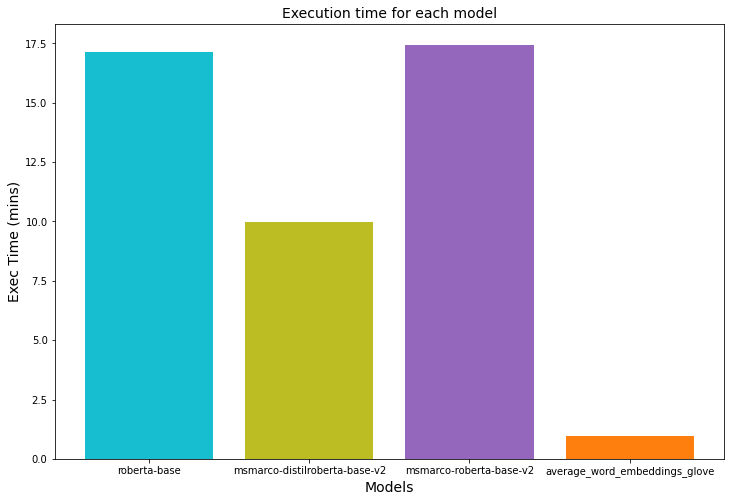

In [11]:
models = ['roberta-base', 'msmarco-distilroberta-base-v2', 'msmarco-roberta-base-v2', 'average_word_embeddings_glove']
results = [instance_1.get_exec_time(), instance_2.get_exec_time(), instance_3.get_exec_time(), instance_4.get_exec_time()]
# leeets go lakers
plt.figure(figsize = (12,8))
plt.bar(models, results, color = ['tab:cyan', 'tab:olive', 'tab:purple', 'tab:orange'])
plt.title('Execution time for each model', fontsize=14)
plt.xlabel('Models', fontsize=14)
plt.ylabel('Exec Time (mins)', fontsize=14)
plt.show()

As we can see, the best model regarding the time metric is the one that uses glove embeddings, and this makes absolute sense, because of the nature of those embeddings, that was examined in previous assignments.

The next best is the `msmarco-distilroberta-base-v2`, which is proposed by the SBERT team as the best for information retrieval. This is good news, as we also expect this model to behave well in the other metrics, so it is satisfying to see that it also does not take an extreme amount of time for its execution.

The 2 worst models are the `roberta-base` and the `msmacro-roberta-base-v2`. The one thing that they have in common is that they are RoBERTa based models, so we can assume that this type of models takes more time to execute than the other ones.

To sum up, regarding the time metric, we have a clear winner: the __glove based__ model, who's execution for all of the queries, as well as the construction of the initial embeddings was almost a minute. However, the __distiloberta__ based model does not behave terribly, as the sum of the time of execution is under 20 minutes.

#### Distance for titles

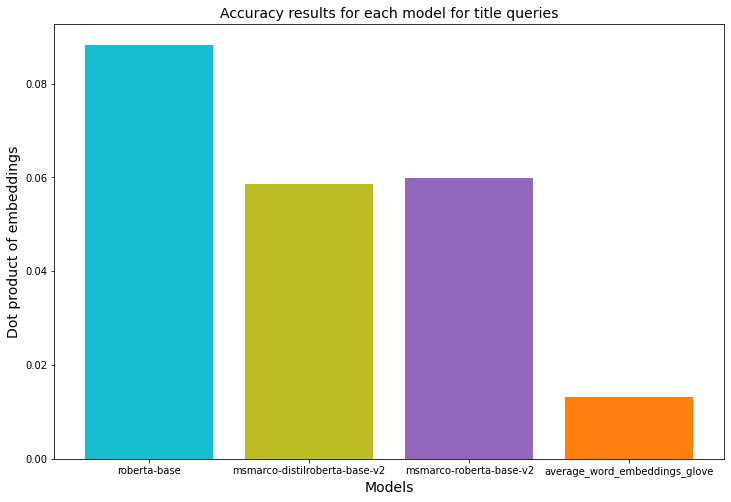

In [12]:
models = ['roberta-base', 'msmarco-distilroberta-base-v2', 'msmarco-roberta-base-v2', 'average_word_embeddings_glove']
results = [instance_1.get_title_acc(), instance_2.get_title_acc(), instance_3.get_title_acc(), instance_4.get_title_acc()]
plt.figure(figsize = (12,8))
plt.bar(models, results, color = ['tab:cyan', 'tab:olive', 'tab:purple', 'tab:orange'])
plt.title('Accuracy results for each model for title queries', fontsize=14)
plt.xlabel('Models', fontsize=14)
plt.ylabel('Dot product of embeddings', fontsize=14)
plt.show()

By observing the similarity when it comes down to titles, it is clear that the simple roberta based model behaves the best. The msmacro models do not behave as well, while the glove model is the worst.

This can be explained because of the comparison of the question to the __title__ of the passage, and not the actual answer. It seems that, for the purpose of returning the best paper containing the answer, the simple roberta-based model is the best.

#### Dstance for passages

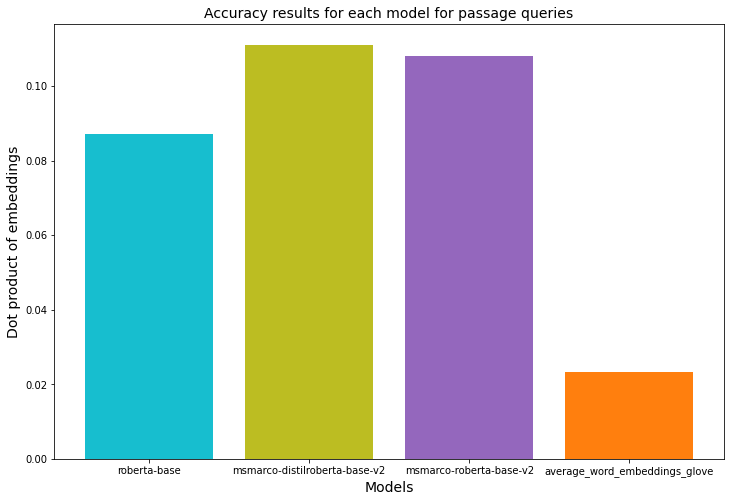

In [13]:
# the k value that was used for queries
k = 5
models = ['roberta-base', 'msmarco-distilroberta-base-v2', 'msmarco-roberta-base-v2', 'average_word_embeddings_glove']
results = [instance_1.get_passage_acc(k), instance_2.get_passage_acc(k), instance_3.get_passage_acc(k), instance_4.get_passage_acc(k)]
plt.figure(figsize = (12,8))
# go lakers go
plt.bar(models, results, color = ['tab:cyan', 'tab:olive', 'tab:purple', 'tab:orange'])
plt.title('Accuracy results for each model for passage queries', fontsize=14)
plt.xlabel('Models', fontsize=14)
plt.ylabel('Dot product of embeddings', fontsize=14)
plt.show()

By observing the results of the dot product similarity, it is clear that the seocnd model (distiloberta based, trained for IR), has the besh behaviour. By taking into account its performance on the time metric, we can safely conclude that this is the overall best model that we used. 

The GLOVE-based model has the worst results, despite being executed fast. Thus, this is a model that we should not consider while running queries.

The other 2 models pose similar behaviour, but slightly worse than the second one. This is an acceptable accuracy, as we also saw during the query answering.

To conclude, the best overall model that we tested is the __distiloberta msmacro__ model.